In [1]:
# This notebook is for visualizing the geodesic distance, T1w/T2w ratio (myelin) map, FEOBV PET maps 
# and computing their relationship with our functional, structural and weighted corctical residual maps.

# Includes:
#      loading geodesic distance map and visualize
#      loading myelin map and visualize
#      loading functional and structural conn matrices and visualize / compare with geodesic
#      correlation between geodesic, myelin map and func / struct
#      spin test (whole brain / parcellated brain) correlation

In [1]:
import os
from neuromaps import images
import numpy as np
import nibabel as nib
from sklearn import preprocessing
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage
from numpy import load
import seaborn as sns
import matplotlib.pyplot as plt
from neuromaps import stats
from neuromaps import datasets, images, nulls, resampling
from neuromaps import parcellate
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
import pandas as pd
from neuromaps import datasets
from neuromaps import images
from neuromaps import stats
from neuromaps.datasets import available_annotations
from neuromaps.datasets import available_tags
from neuromaps.datasets import fetch_annotation

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Setting path

In [2]:
# Set this to your git-repo path for running the analyses.
main_path = "/srv/khan/users/sudesnac/00_Projects/HumanBF-Connectivity"

In [3]:
# Setting other paths
data_path = main_path + "/data/"
results_path = main_path + "/results/connectivity_distance/"
fig_path = main_path + "/results/connectivity_distance/figures/"

In [4]:
Func_results = main_path + "/results/Func_gradients/"
Diff_results = main_path + "/results/Diff_gradients/"
Gradc_results = main_path + "/results/gradient_correlation/"

### Load & visualize geodesic distance (pial) + BF seed - whole brain

In [5]:
# geodesic Distance
# data_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/resources/"
geodesic_lh = images.load_gifti(data_path + "seed-BASF_geodesic-distance-no-zeros.pial.lh.shape.gii")
geodesic_rh = images.load_gifti(data_path + "seed-BASF_geodesic-distance-no-zeros.pial.rh.shape.gii")

In [6]:
geodesic_lh_data = geodesic_lh.agg_data()
geodesic_rh_data = geodesic_rh.agg_data()
geodesic_data = np.concatenate((geodesic_lh_data, geodesic_rh_data))

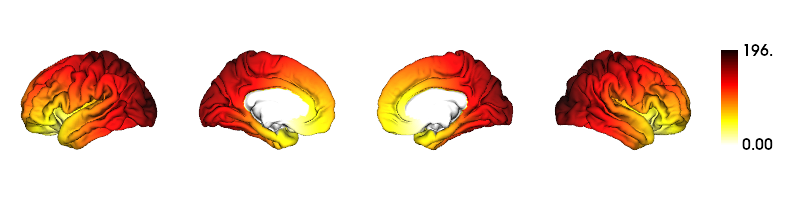

In [7]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodesic_data], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

In [5]:
# getting the surface BF label
BF_lh = images.load_gifti(data_path + "seed-BASF.L.bin.fsa5.shape.gii")
BF_rh = images.load_gifti(data_path + "seed-BASF.R.bin.fsa5.shape.gii")

In [6]:
BF_lh_data = BF_lh.agg_data()
BF_rh_data = BF_rh.agg_data()
BF_data = np.concatenate((BF_lh_data, BF_rh_data))

In [7]:
# scale the geodesic and BF data 
min_max_scaler = preprocessing.MinMaxScaler()
BF_scaled_data = min_max_scaler.fit_transform(BF_data.reshape(-1, 1))

In [11]:
geodesic_scaled_data = min_max_scaler.fit_transform(geodesic_data.reshape(-1, 1))

In [8]:
np.where(BF_scaled_data == 1)

(array([11428, 16986]), array([0, 0]))

In [9]:
# change so the scaled data is binarized for BF seed
BF_scaled_data = np.where(BF_scaled_data == 0.5, 1, BF_scaled_data)
np.where(BF_scaled_data==1)

(array([   78,   600,  1335,  1337,  2438,  3255,  3256,  3257,  5448,
         5452,  7014,  7015,  8476,  8477,  9873,  9874,  9875,  9878,
         9879,  9880, 10324, 10443, 11205, 11206, 11428, 11754, 11755,
        11756, 11757, 11758, 13125, 13126, 13723, 13728, 14570, 14571,
        14572, 15678, 16583, 16584, 16585, 16986, 17610, 17612, 17613,
        17614, 17616, 17617, 17618, 17619, 17620, 18752, 20086, 20087,
        20095, 20096]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

### Load & visualize average T1w/T2w (Myelin Maps)

In [42]:
myelin_lh = images.load_gifti(data_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-L_feature.func.gii")
myelin_rh = images.load_gifti(data_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-R_feature.func.gii")

In [43]:
myelin_lh_data = myelin_lh.agg_data()
myelin_rh_data = myelin_rh.agg_data()
myelin_data = np.concatenate((myelin_lh_data, myelin_rh_data))

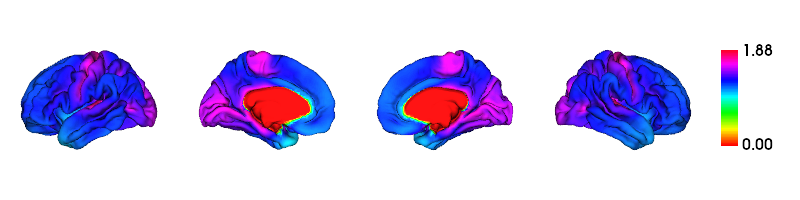

In [44]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[myelin_data], size=(800, 200), cmap=['hsv'], color_bar=True, embed_nb=True)

In [45]:
myelin_scaled_data = min_max_scaler.fit_transform(myelin_data.reshape(-1, 1))

/tmp/ipykernel_1389763/3458447987.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


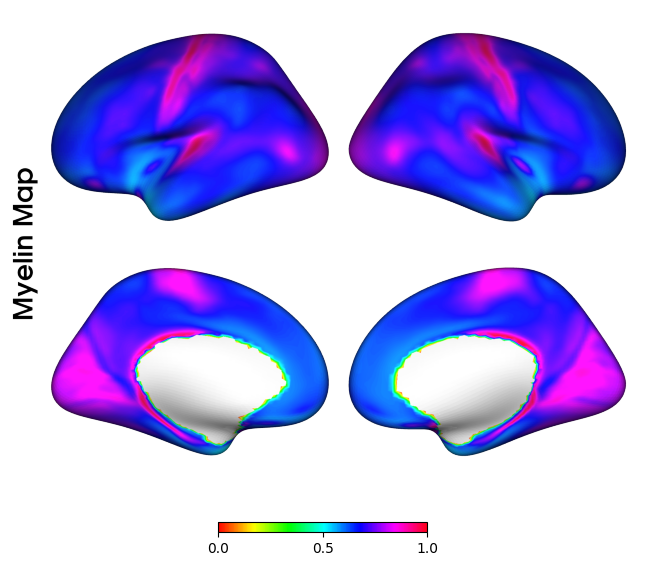

In [21]:
# plot both BF and myelin map together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Myelin Map']}, brightness=.8)
p.add_layer(myelin_scaled_data.reshape([20484]), cmap='hsv', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'wholebrain_myelin_map_BFseed_grid.png', dpi=300)

### VAChT FEOBV PET maps

#### loading neuromaps PET data

In [46]:
Aghourian_FEOBV = datasets.fetch_annotation(source='aghourian2017', desc='feobv')
print(Aghourian_FEOBV)
Bedard_FEOBV = datasets.fetch_annotation(source='bedard2019', desc='feobv')
print(Bedard_FEOBV)
Tuominen_FEOBV = datasets.fetch_annotation(source='tuominen', desc='feobv')
print(Tuominen_FEOBV)

 ...done. (1 seconds, 0 min)


/home/ROBARTS/schakraborty/neuromaps-data/annotations/aghourian2017/feobv/MNI152/source-aghourian2017_desc-feobv_space-MNI152_res-1mm_feature.nii.gz


 ...done. (2 seconds, 0 min)


/home/ROBARTS/schakraborty/neuromaps-data/annotations/bedard2019/feobv/MNI152/source-bedard2019_desc-feobv_space-MNI152_res-1mm_feature.nii.gz
/home/ROBARTS/schakraborty/neuromaps-data/annotations/tuominen/feobv/MNI152/source-tuominen_desc-feobv_space-MNI152_res-2mm_feature.nii.gz


 ...done. (1 seconds, 0 min)


In [47]:
# transform the data to fsaverage 10k space 
from neuromaps import transforms
Aghourian_FEOBV_fsa = transforms.mni152_to_fsaverage(Aghourian_FEOBV, '10k')
Bedard_FEOBV_fsa = transforms.mni152_to_fsaverage(Bedard_FEOBV, '10k')
Tuominen_FEOBV_fsa = transforms.mni152_to_fsaverage(Tuominen_FEOBV, '10k')

In [48]:
Aghourian_FEOBV_fsa_lh, Aghourian_FEOBV_fsa_rh = Aghourian_FEOBV_fsa
Aghourian_FEOBV_fsa_lh_data = Aghourian_FEOBV_fsa_lh.agg_data()
Aghourian_FEOBV_fsa_rh_data = Aghourian_FEOBV_fsa_rh.agg_data()
Aghourian_FEOBV_fsa_data = np.concatenate((Aghourian_FEOBV_fsa_lh_data, Aghourian_FEOBV_fsa_rh_data))

In [49]:
Bedard_FEOBV_fsa_lh, Bedard_FEOBV_fsa_rh = Bedard_FEOBV_fsa
Bedard_FEOBV_fsa_lh_data = Bedard_FEOBV_fsa_lh.agg_data()
Bedard_FEOBV_fsa_rh_data = Bedard_FEOBV_fsa_rh.agg_data()
Bedard_FEOBV_fsa_data = np.concatenate((Bedard_FEOBV_fsa_lh_data, Bedard_FEOBV_fsa_rh_data))

In [50]:
Tuominen_FEOBV_fsa_lh, Tuominen_FEOBV_fsa_rh = Tuominen_FEOBV_fsa
Tuominen_FEOBV_fsa_lh_data = Tuominen_FEOBV_fsa_lh.agg_data()
Tuominen_FEOBV_fsa_rh_data = Tuominen_FEOBV_fsa_rh.agg_data()
Tuominen_FEOBV_fsa_data = np.concatenate((Tuominen_FEOBV_fsa_lh_data, Tuominen_FEOBV_fsa_rh_data))

#### visualize 

/tmp/ipykernel_1389763/2574405775.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


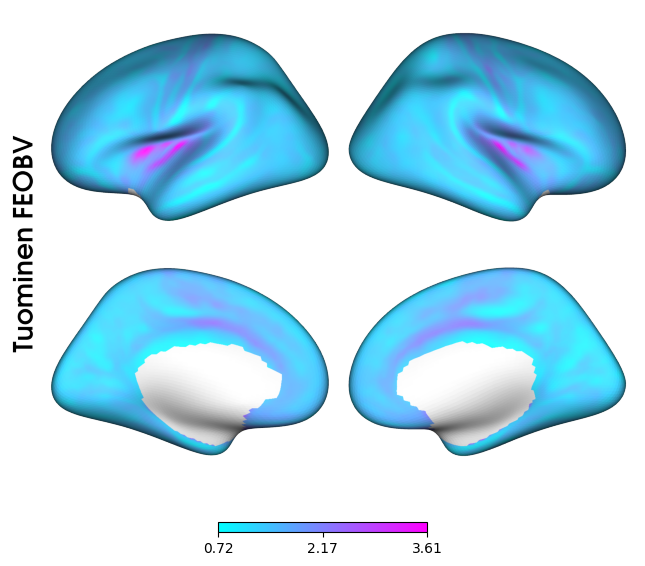

In [33]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

# mask the medial wall first 
Aghourian_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Aghourian_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0
Bedard_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Bedard_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0
Tuominen_FEOBV_fsa_lh_data[np.logical_not(med_lh_data)] = 0
Tuominen_FEOBV_fsa_rh_data[np.logical_not(med_rh_data)] = 0

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Tuominen FEOBV']}, brightness=.8)
#p.add_layer({'left': Aghourian_FEOBV_fsa_lh_data, 'right': Aghourian_FEOBV_fsa_rh_data}, cmap='cool', cbar=True)
#p.add_layer({'left': Bedard_FEOBV_fsa_lh_data, 'right': Bedard_FEOBV_fsa_rh_data}, cmap='cool', cbar=True)
p.add_layer({'left': Tuominen_FEOBV_fsa_lh_data, 'right': Tuominen_FEOBV_fsa_rh_data}, cmap='cool', cbar=True)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_orig_Tuominen_FEOBV_inflated_grid.png', dpi=300)

#### Michigan Data load

In [51]:
# This PET data is not publicly available - available upon request
mic_corr = nib.load(data_path+f't2a_wProject_TWS_001_FEOBV_pvcwac_1-13.nii')

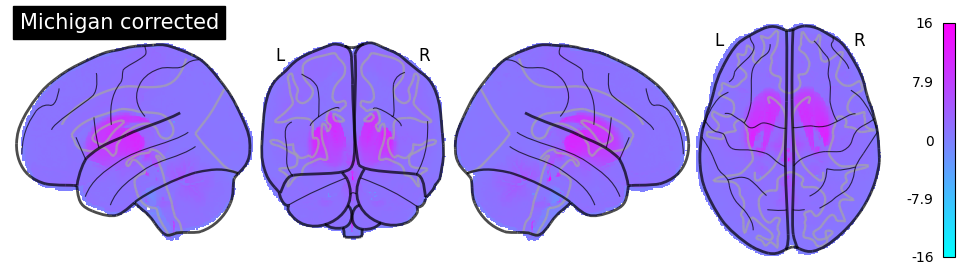

In [31]:
import matplotlib.cm
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_roi
niifile = mic_corr
color = matplotlib.cm.get_cmap('cool')
plot_glass_brain(niifile, colorbar=True, title=("Michigan corrected"), display_mode='lyrz', plot_abs=False, cmap=color)

In [52]:
# transform to fsaverage 10k space
mic_corr_fsa = transforms.mni152_to_fsaverage(mic_corr, '10k')

In [53]:
mic_corr_fsa_lh, mic_corr_fsa_rh = mic_corr_fsa
mic_corr_fsa_lh_data = mic_corr_fsa_lh.agg_data()
mic_corr_fsa_rh_data = mic_corr_fsa_rh.agg_data()
mic_corr_data = np.concatenate((mic_corr_fsa_lh_data, mic_corr_fsa_rh_data))

/tmp/ipykernel_1389763/2425716741.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


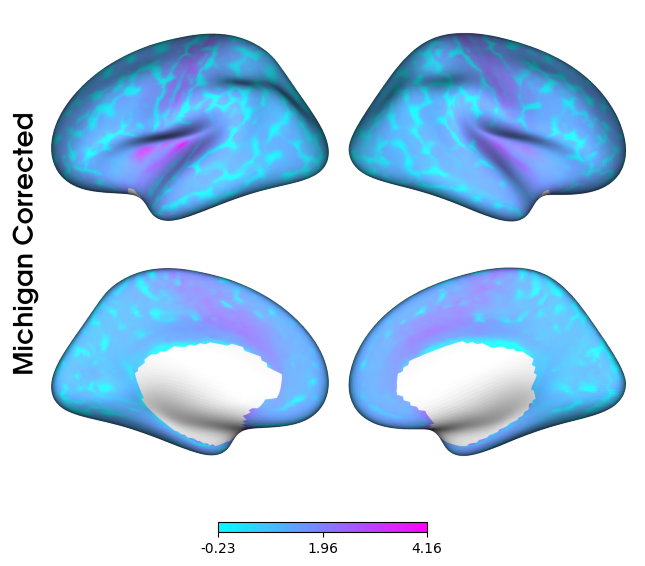

In [32]:
from neuromaps.datasets import fetch_fsaverage
from surfplot import Plot
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

med_lh, med_rh = surfaces['medial']
# get medial wall gifti - array for masking the data
med_lh_img = images.load_gifti(med_lh)
med_lh_data = med_lh_img.agg_data()
med_rh_img = images.load_gifti(med_rh)
med_rh_data = med_rh_img.agg_data()

# mask the medial wall first 
mic_corr_fsa_lh_data[np.logical_not(med_lh_data)] = 0
mic_corr_fsa_rh_data[np.logical_not(med_rh_data)] = 0

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Michigan Corrected']}, brightness=.8)
p.add_layer({'left': mic_corr_fsa_lh_data, 'right': mic_corr_fsa_rh_data}, cmap='cool', cbar=True)
fig = p.build()
fig.show()

#### Rescale the data

In [54]:
min_max_scaler = preprocessing.MinMaxScaler()
Aghourian_scaled_data = min_max_scaler.fit_transform(Aghourian_FEOBV_fsa_data.reshape(-1, 1))
Bedard_scaled_data = min_max_scaler.fit_transform(Bedard_FEOBV_fsa_data.reshape(-1, 1))
Tuominen_scaled_data = min_max_scaler.fit_transform(Tuominen_FEOBV_fsa_data.reshape(-1, 1))

In [55]:
min_max_scaler = preprocessing.MinMaxScaler()
mic_corr_scaled_data = min_max_scaler.fit_transform(mic_corr_data.reshape(-1, 1))

/tmp/ipykernel_1389763/3570451578.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


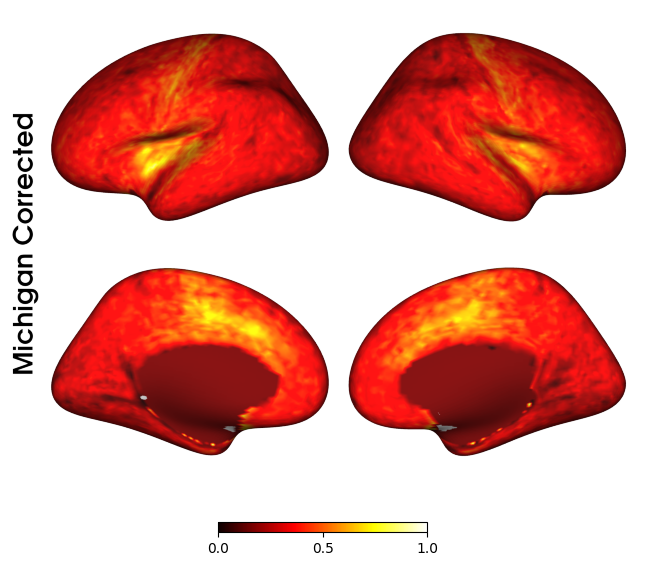

In [60]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Michigan Corrected']}, brightness=.8)
p.add_layer(Aghourian_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(Bedard_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(Tuominen_scaled_data.reshape([20484]), cmap='hot', cbar=True, color_range=[0,1])
#p.add_layer(mic_uncorr_scaled_data.reshape([20484]), cmap='Spectral', cbar=True, color_range=[0,1])
#p.add_layer(mic_corr_scaled_data.reshape([20484]), cmap='Spectral_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_scaled_Michigan_FEOBV_inflated_grid.png', dpi=300)

### Loading functional and diffusion connectivity data

#### Functional data

In [18]:
func_corr = pd.read_csv(Func_results + f'Func_corr-avgFC.csv')

In [19]:
func_ctx = np.nanmean(func_corr,axis=0).reshape([360,1])

In [39]:
abs_func_ctx = pd.read_csv(Func_results + f'Func_abs-corr-avgFC.csv')

In [40]:
abs_func_ctx = np.nanmean(abs_func_ctx,axis=0).reshape([360,1])

#### Diffusion data

In [24]:
diff_corr = pd.read_csv(Diff_results + f'Diff_corr-avgFC.csv')

In [25]:
log_diff_corr = np.log(diff_corr)

In [26]:
diff_ctx = np.nanmean(log_diff_corr,axis=0).reshape([360,1])

#### Visualize

In [42]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [ ]:
func_cortex = map_to_labels(func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
abs_func_cortex = map_to_labels(abs_func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diff_cortex = map_to_labels(diff_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [43]:
abs_func_cortex = map_to_labels(abs_func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

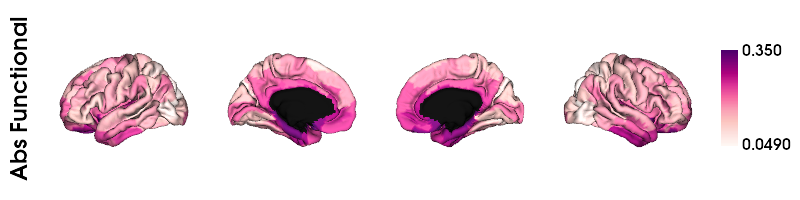

In [31]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[abs_func_cortex], size=(800, 200), cmap=['RdPu'], label_text=['Abs Functional'], color_bar=True, embed_nb=True)

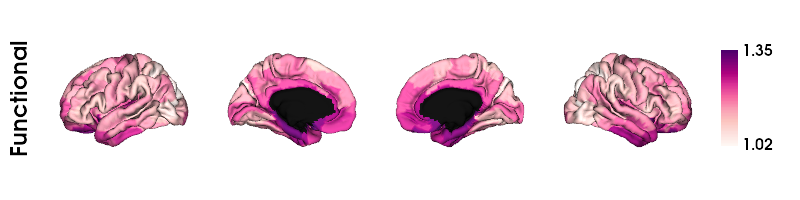

In [32]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[func_cortex], size=(800, 200), cmap=['RdPu'], label_text=['Functional'], color_bar=True, embed_nb=True)

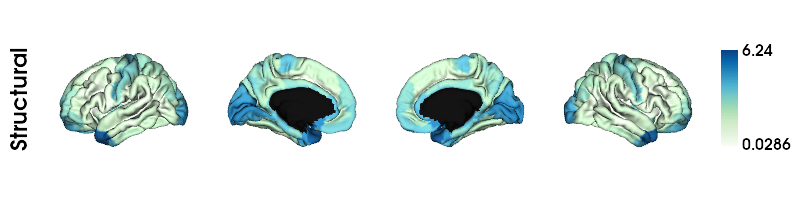

In [50]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_cortex], size=(800, 200), cmap=['GnBu'], label_text=['Structural'], color_bar=True, embed_nb=True)

### Getting cortical residual data

In [33]:
weighted_sqresid = pd.read_csv(Gradc_results + 'Gradient-weighted-map_Struct_vs_Func_linear_least-squares_regression_weighted-s6-f4_residuals_statsmodels.csv')

In [34]:
weighted_sumsq = weighted_sqresid.sum(axis=1).to_numpy()
weighted_sumsq.shape

(360,)

In [35]:
weighted_sumsq_cortex = map_to_labels(weighted_sumsq, surf_labels, mask=mask, fill=np.nan)

In [34]:
G1s_sqresid = pd.read_csv(Gradc_results + 'Gradient-weighted-map_Struct_vs_Func_linear_least-squares_regression_s6-f4_residuals-squared.csv')['(0, 0)'].values
G1s_sqresid.shape

(360,)

In [35]:
G1s_sqresid_cortex = map_to_labels(G1s_sqresid, surf_labels, mask=mask, fill=np.nan)

In [36]:
unweighted_sumsq = pd.read_csv(Gradc_results + 'Gradient-weighted-map_Struct_vs_Func_linear_least-squares_regression_s6-f4_residuals-squared.csv')
unweighted_sumsq = unweighted_sumsq.sum(axis=1).to_numpy()
unweighted_sumsq.shape

(360,)

In [37]:
unweighted_sumsq_cortex = map_to_labels(unweighted_sumsq, surf_labels, mask=mask, fill=np.nan)

#### Rescale data

In [40]:
# rescale the  data 
min_max_scaler = preprocessing.MinMaxScaler()
func_scaled_ctx = min_max_scaler.fit_transform(func_cortex.reshape(-1, 1))
abs_func_scaled_ctx = min_max_scaler.fit_transform(abs_func_cortex.reshape(-1, 1))
diff_scaled_ctx = min_max_scaler.fit_transform(diff_cortex.reshape(-1, 1))
weighted_resid_scaled_data = min_max_scaler.fit_transform(weighted_sumsq_cortex.reshape(-1, 1))

### Saving all whole brain rescaled data

In [56]:
wholeB_data = {'labels':surf_labels.reshape([20484]), 'geodesic':geodesic_scaled_data.reshape([20484]), 'myelin':myelin_scaled_data.reshape([20484]),
              'Michigan_FEOBV':mic_corr_scaled_data.reshape([20484]), 'Aghourian_FEOBV':Aghourian_scaled_data.reshape([20484]), 
              'Bedard_FEOBV':Bedard_scaled_data.reshape([20484]), 'Tuominen_FEOBV':Tuominen_scaled_data.reshape([20484]),
              'functional':func_scaled_ctx.reshape([20484]), 'abs_functional':abs_func_scaled_ctx.reshape([20484]), 'structural':diff_scaled_ctx.reshape([20484]), 
              'wresidC':weighted_resid_scaled_data.reshape([20484])}
wholeB_df = pd.DataFrame(data=wholeB_data)

In [57]:
wholeB_df.head(5)

labels  geodesic    myelin  Michigan_FEOBV  Aghourian_FEOBV  Bedard_FEOBV  \
0      54  0.796473  0.854568        0.054785         0.417560      0.204726   
1      46  0.911204  0.691224        0.212449         0.318734      0.160899   
2      41  0.564919  0.721838        0.507094         0.553509      0.358201   
3      87  0.552300  0.641402        0.266954         0.271154      0.194378   
4      99  0.450188  0.707502        0.417403         0.466666      0.282197   

   Tuominen_FEOBV  functional  abs_functional  structural   wresidC  
0        0.265337    0.469834        0.416659    0.415276  0.010250  
1        0.193347    0.210992        0.193602    0.404432  0.119060  
2        0.382737    0.521383        0.473378    0.114198  0.179069  
3        0.198943    0.341724        0.278304    0.418003  0.102859  
4        0.304123    0.377407        0.353387    0.144557  0.410765

In [58]:
# set the geodesic medial wall to nan instead of 0 
wholeB_df.loc[wholeB_df.labels == 0, 'geodesic'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'myelin'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'functional'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'structural'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'wresidC'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'Michigan_FEOBV'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'Aghourian_FEOBV'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'Bedard_FEOBV'] = np.nan
wholeB_df.loc[wholeB_df.labels == 0, 'Tuominen_FEOBV'] = np.nan

In [59]:
# remove 0 for better visualization
wholeB_df.loc[wholeB_df.structural == 0, 'structural'] = 0.000001
wholeB_df.loc[wholeB_df.functional == 0, 'functional'] = 0.000001
wholeB_df.loc[wholeB_df.wresidC == 0, 'wresidC'] = 0.000001
wholeB_df.loc[wholeB_df.geodesic == 0, 'geodesic'] = 0.000001

In [60]:
# check
wholeB_df.loc[(wholeB_df.myelin == 0)]

Empty DataFrame
Columns: [labels, geodesic, myelin, Michigan_FEOBV, Aghourian_FEOBV, Bedard_FEOBV, Tuominen_FEOBV, functional, abs_functional, structural, wresidC]
Index: []

In [61]:
# save
pd.DataFrame(wholeB_df).to_csv(results_path + 'rescaled_whole_brain_data.csv', index=False)

### Parcellate then rescale geodesic, myelin, VAChT to match func and diff data

In [62]:
# load the hcp-mmp1 parcellation gii file
# or fetch the file
# glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [63]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

In [64]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [65]:
geodesic_parc = hcpmmp.transform(geodesic_data, 'fsaverage', ignore_background_data=True)
myelin_parc = hcpmmp.transform(myelin_data, 'fsaverage', ignore_background_data=True)

In [66]:
Aghourian_parc = hcpmmp.transform(Aghourian_FEOBV_fsa_data, 'fsaverage', ignore_background_data=True)
Bedard_parc = hcpmmp.transform(Bedard_FEOBV_fsa_data, 'fsaverage', ignore_background_data=True)
Tuominen_parc = hcpmmp.transform(Tuominen_FEOBV_fsa_data, 'fsaverage', ignore_background_data=True)
MicCorr_parc = hcpmmp.transform(mic_corr_data, 'fsaverage', ignore_background_data=True)

In [67]:
min_max_scaler = preprocessing.MinMaxScaler()
Geodesic_parc_scaled_data = min_max_scaler.fit_transform(geodesic_parc.reshape(-1, 1))
Myelin_parc_scaled_data = min_max_scaler.fit_transform(myelin_parc.reshape(-1, 1))
MicCorr_parc_scaled_data = min_max_scaler.fit_transform(MicCorr_parc.reshape(-1, 1))
Aghourian_parc_scaled_data = min_max_scaler.fit_transform(Aghourian_parc.reshape(-1, 1))
Bedard_parc_scaled_data = min_max_scaler.fit_transform(Bedard_parc.reshape(-1, 1))
Tuominen_parc_scaled_data = min_max_scaler.fit_transform(Tuominen_parc.reshape(-1, 1))

In [68]:
abs_func_parc = hcpmmp.transform(abs_func_scaled_ctx, 'fsaverage', ignore_background_data=True)
func_parc = hcpmmp.transform(func_scaled_ctx, 'fsaverage', ignore_background_data=True)
diff_parc = hcpmmp.transform(diff_scaled_ctx, 'fsaverage', ignore_background_data=True)
wresidC_parc = hcpmmp.transform(weighted_resid_scaled_data, 'fsaverage', ignore_background_data=True)

In [69]:
parc_rescaled_data = {'Geodesic':Geodesic_parc_scaled_data.reshape([360]), 'Myelin':Myelin_parc_scaled_data.reshape([360]), 
                      'Michigan_FEOBV':MicCorr_parc_scaled_data.reshape([360]), 'Aghourian_FEOBV':Aghourian_parc_scaled_data.reshape([360]), 
                      'Bedard_FEOBV':Bedard_parc_scaled_data.reshape([360]), 'Tuominen_FEOBV':Tuominen_parc_scaled_data.reshape([360]),
                     'functional':func_parc, 'abs_functional':abs_func_parc,'structural':diff_parc, 'wresidC':wresidC_parc}
parc_rescaled_df = pd.DataFrame(data=parc_rescaled_data)

In [70]:
parc_rescaled_df.loc[parc_rescaled_df.Geodesic == 0, 'Geodesic'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.Myelin == 0, 'Myelin'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.Michigan_FEOBV == 0, 'Michigan_FEOBV'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.Aghourian_FEOBV == 0, 'Aghourian_FEOBV'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.Bedard_FEOBV == 0, 'Bedard_FEOBV'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.Tuominen_FEOBV == 0, 'Tuominen_FEOBV'] = 0.000001
parc_rescaled_df.loc[parc_rescaled_df.functional == 0, 'functional'] = 0.000001

In [71]:
# check
parc_rescaled_df.loc[(parc_rescaled_df.functional== 0)]

Empty DataFrame
Columns: [Geodesic, Myelin, Michigan_FEOBV, Aghourian_FEOBV, Bedard_FEOBV, Tuominen_FEOBV, functional, abs_functional, structural, wresidC]
Index: []

In [72]:
# Save 
pd.DataFrame(parc_rescaled_df).to_csv(results_path + 'parc_rescaled_all_data.csv', index=False)

#### add aditional data for extra analysis

In [74]:
parc_rescaled = pd.read_csv(results_path + 'parc_rescaled_all_data.csv')

In [75]:
parc_rescaled

Geodesic    Myelin  Michigan_FEOBV  Aghourian_FEOBV  Bedard_FEOBV  \
0    0.718208  0.725158        0.307165         0.284614      0.040923   
1    0.756606  0.635854        0.393784         0.401920      0.107447   
2    0.756608  0.647891        0.341122         0.303877      0.042400   
3    0.719054  0.671180        0.280373         0.227710      0.032227   
4    0.779794  0.632432        0.181810         0.279805      0.076867   
..        ...       ...             ...              ...           ...   
355  0.442331  0.256823        0.554505         0.459290      0.254334   
356  0.560568  0.266042        0.289936         0.372814      0.175223   
357  0.216424  0.161699        0.678257         0.426209      0.311874   
358  0.309827  0.227378        0.695732         0.673738      0.280750   
359  0.199730  0.126194        0.704833         0.711029      0.265630   

     Tuominen_FEOBV  functional  abs_functional  structural   wresidC  
0          0.196568    0.563640        0.519885    0.805695  0.100994  
1          0.209680    0.164174        0.106873    0.112599  0.050152  
2          0.192183    0.138740        0.103628    0.433660  0.051173  
3          0.171076    0.377697        0.316383    0.731491  0.044553  
4          0.147329    0.315332        0.253073    0.684552  0.026488  
..              ...         ...             ...         ...       ...  
355        0.247783    0.595161        0.571793    0.202580  0.426654  
356        0.167511    0.549909        0.511467    0.163962  0.110377  
357        0.437831    0.547436        0.522263    0.294434  0.317268  
358        0.338893    0.557818        0.535859    0.181482  0.411807  
359        0.516453    0.747320        0.721977    0.591108  0.216542  

[360 rows x 10 columns]

In [44]:
min_max_scaler = preprocessing.MinMaxScaler()
abs_func_scaled_ctx = min_max_scaler.fit_transform(abs_func_cortex.reshape(-1, 1))
unweighted_resid_scaled_data = min_max_scaler.fit_transform(unweighted_sumsq_cortex.reshape(-1, 1))
G1s_resid_scaled_data = min_max_scaler.fit_transform(G1s_sqresid_cortex.reshape(-1, 1))

In [45]:
abs_func_parc = hcpmmp.transform(abs_func_scaled_ctx, 'fsaverage', ignore_background_data=True)
G1sresidC_parc = hcpmmp.transform(G1s_resid_scaled_data, 'fsaverage', ignore_background_data=True)
unwresidC_parc = hcpmmp.transform(unweighted_resid_scaled_data, 'fsaverage', ignore_background_data=True)

In [46]:
parc_rescaled['abs_functional'] = abs_func_parc
parc_rescaled['G1residC'] = G1sresidC_parc 
parc_rescaled['unwresidC'] = unwresidC_parc

In [47]:
parc_rescaled

Geodesic    Myelin  Michigan_FEOBV  Aghourian_FEOBV  Bedard_FEOBV  \
0    0.718208  0.725158        0.307165         0.284614      0.040923   
1    0.756606  0.635854        0.393784         0.401920      0.107447   
2    0.756608  0.647891        0.341122         0.303877      0.042400   
3    0.719054  0.671180        0.280373         0.227710      0.032227   
4    0.779794  0.632432        0.181810         0.279805      0.076867   
..        ...       ...             ...              ...           ...   
355  0.442331  0.256823        0.554505         0.459290      0.254334   
356  0.560568  0.266042        0.289936         0.372814      0.175223   
357  0.216424  0.161699        0.678257         0.426209      0.311874   
358  0.309827  0.227378        0.695732         0.673738      0.280750   
359  0.199730  0.126194        0.704833         0.711029      0.265630   

     Tuominen_FEOBV  functional  abs_functional  structural   wresidC  \
0          0.196568    0.563640        0.519885    0.805695  0.100994   
1          0.209680    0.164174        0.106873    0.112599  0.050152   
2          0.192183    0.138740        0.103628    0.433660  0.051173   
3          0.171076    0.377697        0.316383    0.731491  0.044553   
4          0.147329    0.315332        0.253073    0.684552  0.026488   
..              ...         ...             ...         ...       ...   
355        0.247783    0.595161        0.571793    0.202580  0.426654   
356        0.167511    0.549909        0.511468    0.163962  0.110377   
357        0.437831    0.547436        0.522263    0.294434  0.317268   
358        0.338893    0.557818        0.535859    0.181482  0.411807   
359        0.516453    0.747320        0.721977    0.591108  0.216542   

     G1residC  unwresidC  
0    0.062583   0.105678  
1    0.037691   0.050892  
2    0.023673   0.053624  
3    0.025218   0.046576  
4    0.010557   0.028410  
..        ...        ...  
355  0.414489   0.423854  
356  0.106708   0.109670  
357  0.289798   0.316929  
358  0.380788   0.405176  
359  0.265091   0.203328  

[360 rows x 12 columns]

In [48]:
pd.DataFrame(parc_rescaled).to_csv(results_path + 'parc_rescaled_all_data.csv', index=False)

##### WholeBrain

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


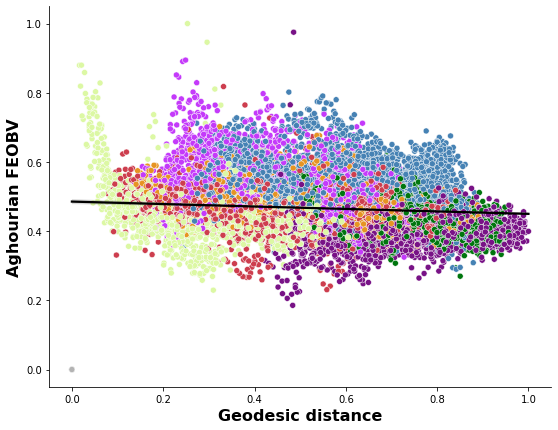

In [113]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Aghourian_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Aghourian_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Aghourian_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


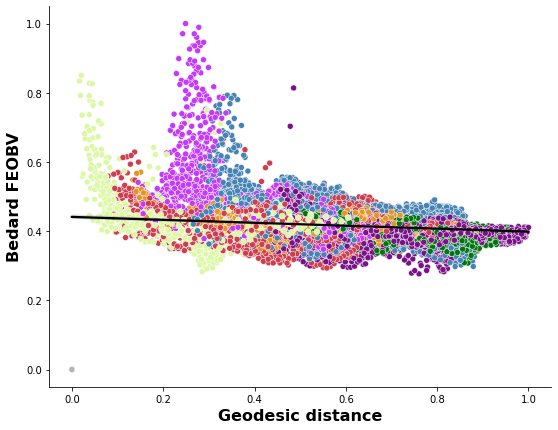

In [112]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Bedard_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Bedard_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Bedard_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


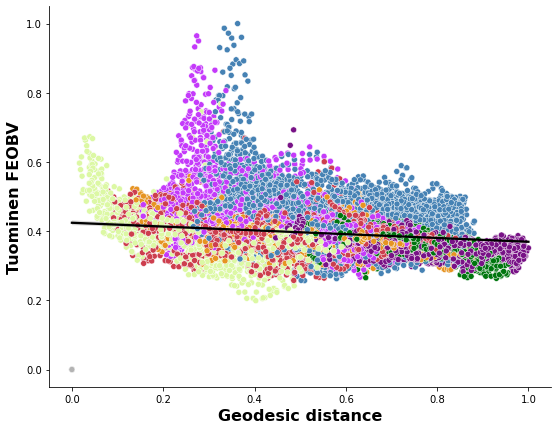

In [114]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_scaled_data, Tuominen_scaled_data.reshape([20484]), hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_scaled_data,
    y=Tuominen_scaled_data.reshape([20484]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'wholebrain_Geodesic_distance_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

#####  Parcellated brain

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


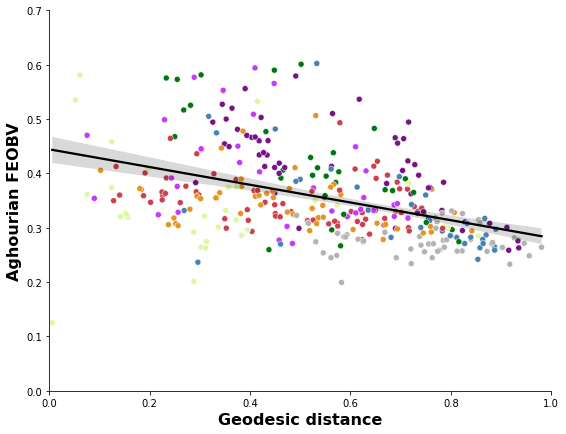

In [28]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Aghourian_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Aghourian_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


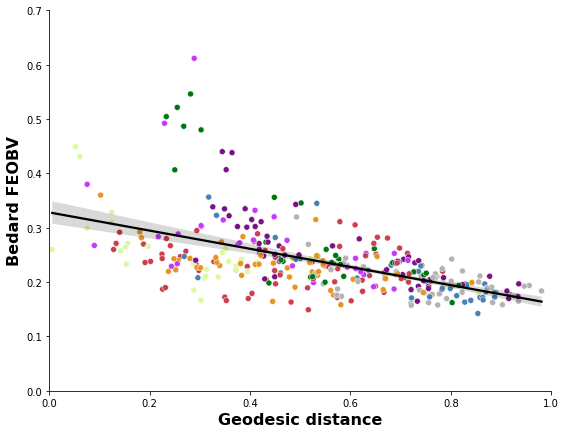

In [29]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Bedard_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Bedard_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


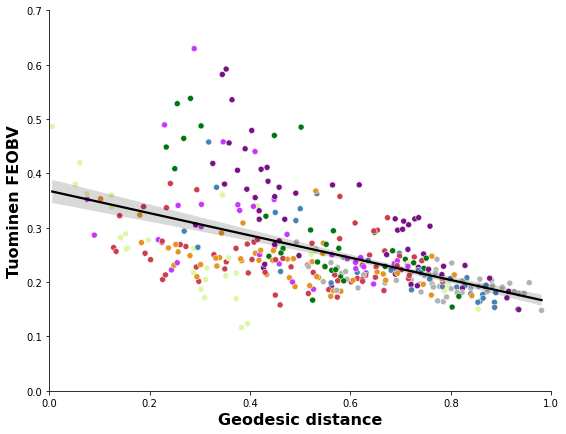

In [31]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Tuominen_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


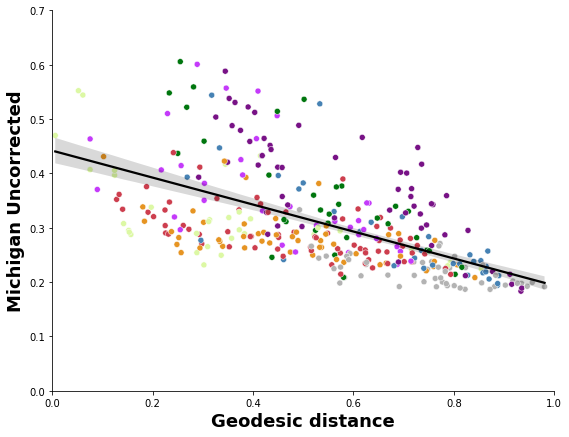

In [96]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, MicUnc_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Michigan Uncorrected', weight='bold', fontsize=18)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=MicUnc_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Michigan-Uncorrected_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


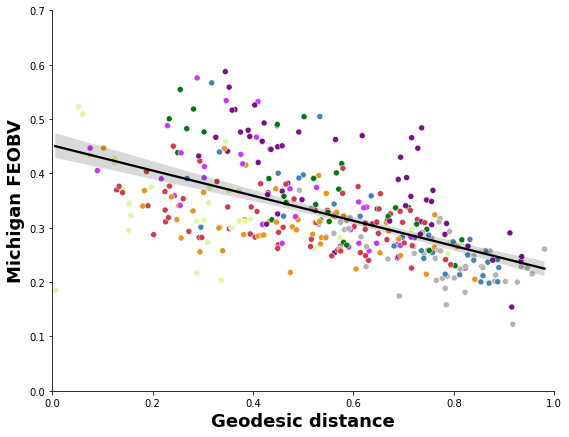

In [97]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Michigan FEOBV', weight='bold', fontsize=18)
ax1.axes.set_ylim(0, 0.7)
ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=MicCorr_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Michigan-Corrected_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


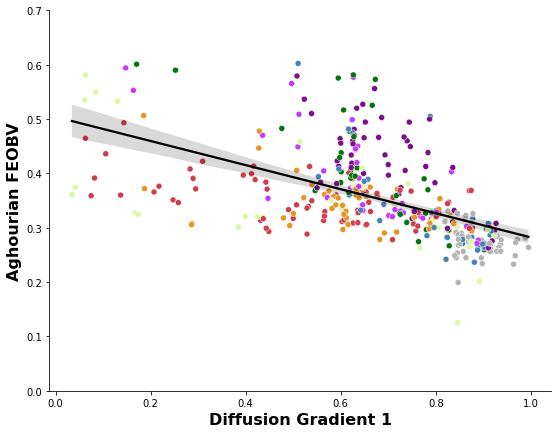

In [35]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Aghourian_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


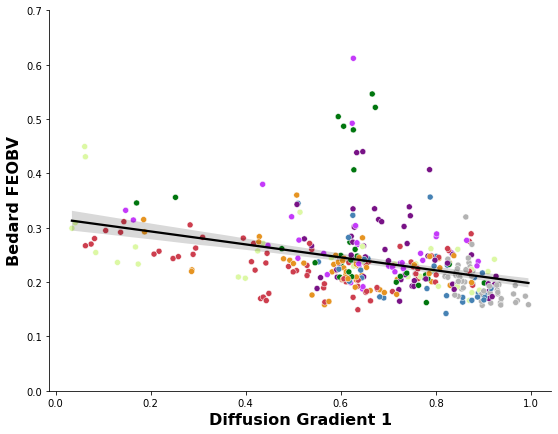

In [36]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Bedard_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


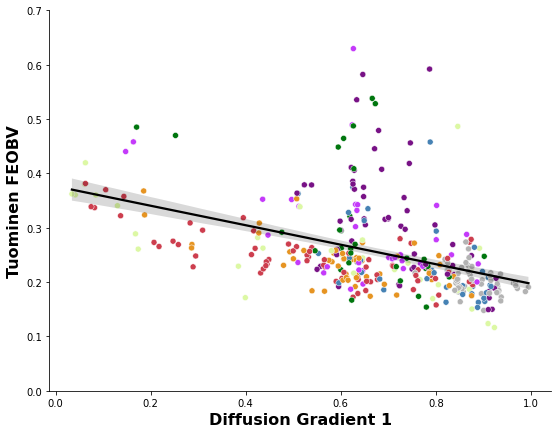

In [34]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(diffG1_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Diffusion Gradient 1', weight='bold', fontsize=16)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=diffG1_parc,
    y=Tuominen_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Diffusion-G1_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

In [57]:
n_perm = 10000

In [118]:
# Whole brain

In [123]:
alex_geodesic_rotated = nulls.alexander_bloch(geodesic_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [164]:
afgc_corr, afgc_pval = stats.compare_images(geodesic_scaled_data, Aghourian_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
afgc_corr, afgc_pval

(-0.3282221023626283, 0.19858014198580143)

In [165]:
bfgc_corr, bfgc_pval = stats.compare_images(geodesic_scaled_data, Bedard_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
bfgc_corr, bfgc_pval

(-0.46641433940443655, 0.0038996100389961006)

In [166]:
tfgc_corr, tfgc_pval = stats.compare_images(geodesic_scaled_data, Tuominen_scaled_data.reshape([20484]), nulls=alex_geodesic_rotated)
tfgc_corr, tfgc_pval

(-0.39722524451984575, 0.0006999300069993001)

In [40]:
alex_diffG1_rotated = nulls.alexander_bloch(diffG1_scaled_data, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234)

In [41]:
afdg1_corr, afdg1_pval = stats.compare_images(diffG1_scaled_data, Aghourian_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
afdg1_corr, afdg1_pval

(-0.45141774515896876, 0.0016998300169983002)

In [42]:
bfdg1_corr, bfdg1_pval = stats.compare_images(diffG1_scaled_data, Bedard_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
bfdg1_corr, bfdg1_pval

(-0.31231085851324514, 0.08649135086491351)

In [43]:
tfdg1_corr, tfdg1_pval = stats.compare_images(diffG1_scaled_data, Tuominen_scaled_data.reshape([20484]), nulls=alex_diffG1_rotated)
tfdg1_corr, tfdg1_pval

(-0.36674306859452815, 0.008599140085991401)

In [58]:
# Parcellated data spin test
geodesic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [44]:
pc_afgc_corr, pc_afgc_pval = stats.compare_images(geodesic_parc, Aghourian_parc, nulls=geodesic_parc_rotated)
pc_afgc_corr, pc_afgc_pval

(-0.4276522696018219, 0.11848815118488151)

In [45]:
pc_bfgc_corr, pc_bfgc_pval = stats.compare_images(geodesic_parc, Bedard_parc, nulls=geodesic_parc_rotated)
pc_bfgc_corr, pc_bfgc_pval

(-0.5590590238571167, 0.0052994700529947)

In [46]:
pc_tfgc_corr, pc_tfgc_pval = stats.compare_images(geodesic_parc, Tuominen_parc, nulls=geodesic_parc_rotated)
pc_tfgc_corr, pc_tfgc_pval

(-0.5375537276268005, 0.00019998000199980003)

In [59]:
pc_mugc_corr, pc_mugc_pval = stats.compare_images(geodesic_parc, MicUnc_parc, nulls=geodesic_parc_rotated)
pc_mugc_corr, pc_mugc_pval

(-0.5921834464994131, 0.0004999500049995)

In [60]:
pc_mcgc_corr, pc_mcgc_pval = stats.compare_images(geodesic_parc, MicCorr_parc, nulls=geodesic_parc_rotated)
pc_mcgc_corr, pc_mcgc_pval

(-0.5854330551791095, 0.00019998000199980003)

In [44]:
diffG1_parc_rotated = nulls.alexander_bloch(diffG1_parc, atlas='fsaverage', density='10k',
                                              n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [45]:
pc_afdg1_corr, pc_afdg1_pval = stats.compare_images(diffG1_parc, Aghourian_parc, nulls=diffG1_parc_rotated)
pc_afdg1_corr, pc_afdg1_pval

(-0.5544192837347244, 0.0052994700529947)

In [46]:
pc_bfdg1_corr, pc_bfdg1_pval = stats.compare_images(diffG1_parc, Bedard_parc, nulls=diffG1_parc_rotated)
pc_bfdg1_corr, pc_bfdg1_pval

(-0.3801590770894699, 0.07979202079792021)

In [47]:
pc_tfdg1_corr, pc_tfdg1_pval = stats.compare_images(diffG1_parc, Tuominen_parc, nulls=diffG1_parc_rotated)
pc_tfdg1_corr, pc_tfdg1_pval

(-0.4483480251285871, 0.0165983401659834)

In [68]:
# Parcellated data spin test
wresid_parc_rotated = nulls.alexander_bloch(wresid_parc, atlas='fsaverage', density='10k',
                                            n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [162]:
pc_afwc_corr, pc_afwc_pval = stats.compare_images(wresid_parc, Aghourian_parc, nulls=wresid_parc_rotated)
pc_afwc_corr, pc_afwc_pval

(0.33188246393552406, 0.0024997500249975004)

In [163]:
pc_bfwc_corr, pc_bfwc_pval = stats.compare_images(wresid_parc, Bedard_parc, nulls=wresid_parc_rotated)
pc_bfwc_corr, pc_bfwc_pval

(0.29267129826437216, 0.012798720127987202)

In [164]:
pc_tfwc_corr, pc_tfwc_pval = stats.compare_images(wresid_parc, Tuominen_parc, nulls=wresid_parc_rotated)
pc_tfwc_corr, pc_tfwc_pval

(0.2573830378425152, 0.0287971202879712)

In [69]:
pc_muwc_corr, pc_muwc_pval = stats.compare_images(wresid_parc, MicUnc_parc, nulls=wresid_parc_rotated)
pc_muwc_corr, pc_muwc_pval

(0.2785920663562592, 0.022397760223977603)

In [70]:
pc_mcwc_corr, pc_mcwc_pval = stats.compare_images(wresid_parc, MicCorr_parc, nulls=wresid_parc_rotated)
pc_mcwc_corr, pc_mcwc_pval

(0.2822861435562684, 0.019698030196980302)

In [111]:
wholeB_df = pd.read_csv(results_path + 'rescaled_whole_brain_all_data.csv')

In [112]:
wholeB_df.head(5)

labels  geodesic    myelin  functional  structural     fused    funcG1  \
0      54  0.796473  0.854568    0.469834    0.415276  0.564902  0.480979   
1      46  0.911204  0.691224    0.210992    0.404432  0.392915  0.687947   
2      41  0.564919  0.721838    0.521383    0.114198  0.254639  0.649486   
3      87  0.552300  0.641402    0.341724    0.418003  0.485461  0.293482   
4      99  0.450188  0.707502    0.377407    0.144557  0.192630  0.820415   

     diffG1    funcG2    diffG2   wresidC  
0  0.550129  0.679370  0.685803  0.010250  
1  0.918590  0.435305  0.664741  0.119060  
2  0.511140  0.660174  0.897476  0.179069  
3  0.565580  0.422960  0.659776  0.102859  
4  0.617225  0.693195  0.627569  0.410765

#### Visualize whole brain

/tmp/ipykernel_987364/1735998896.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


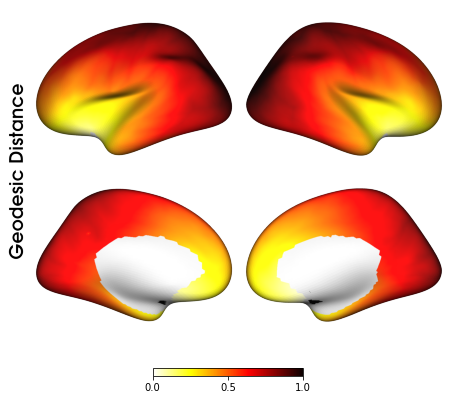

In [32]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodesic Distance']}, brightness=.8)
p.add_layer(wholeB_df['geodesic'].values, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'wholebrain_myelin_map_BFseed_grid.png', dpi=300)

In [99]:
#glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)

In [113]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [114]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

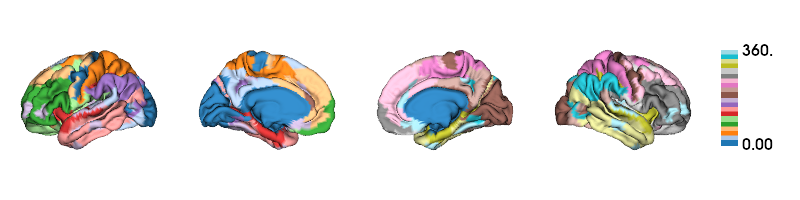

In [35]:
# visualize the parcellation data to double check
hm_lh, hm_rh = hcpmmp_parcellation
parc_L_data = hm_lh.agg_data()
parc_R_data = hm_rh.agg_data()
parc_data = np.concatenate((parc_L_data, parc_R_data))
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[parc_data], size=(800, 200), cmap=['tab20'], color_bar=True, embed_nb=True)

In [115]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [12]:
wholeB_df = pd.read_csv(results_path + 'rescaled_whole_brain_all_data.csv')

In [117]:
# get data
geodesic_scaled_data = wholeB_df['geodesic'].values
myelin_scaled_data = wholeB_df['myelin'].values
func_scaled_data = wholeB_df['functional'].values
diff_scaled_data = wholeB_df['structural'].values
fused_scaled_data = wholeB_df['fused'].values
funcG1_scaled_data = wholeB_df['funcG1'].values
funcG2_scaled_data = wholeB_df['funcG2'].values
diffG1_scaled_data = wholeB_df['diffG1'].values
diffG2_scaled_data = wholeB_df['diffG2'].values
wresid_scaled_data = wholeB_df['wresidC'].values

In [119]:
geodesic_parc = hcpmmp.transform(geodesic_scaled_data, 'fsaverage', ignore_background_data=True)

In [135]:
myelin_parc = hcpmmp.transform(myelin_scaled_data, 'fsaverage', ignore_background_data=True)

In [121]:
func_parc = hcpmmp.transform(func_scaled_data, 'fsaverage', ignore_background_data=True)
diff_parc = hcpmmp.transform(diff_scaled_data, 'fsaverage', ignore_background_data=True)
fused_parc = hcpmmp.transform(fused_scaled_data, 'fsaverage', ignore_background_data=True)

In [122]:
funcG1_parc = hcpmmp.transform(funcG1_scaled_data, 'fsaverage', ignore_background_data=True)
funcG2_parc = hcpmmp.transform(funcG2_scaled_data, 'fsaverage', ignore_background_data=True)

In [123]:
diffG1_parc = hcpmmp.transform(diffG1_scaled_data, 'fsaverage', ignore_background_data=True)
diffG2_parc = hcpmmp.transform(diffG2_scaled_data, 'fsaverage', ignore_background_data=True)

In [118]:
wresid_parc = hcpmmp.transform(wresid_scaled_data, 'fsaverage', ignore_background_data=True)

In [124]:
# Saving parcellated data to csv file
parc_data = {'geodesic':geodesic_parc, 'myelin':myelin_parc, 'functional':func_parc, 'structural':diff_parc, 
             'fused':fused_parc, 'funcG1':funcG1_parc, 'funcG2':funcG2_parc, 'diffG1':diffG1_parc,'diffG2':diffG2_parc,
            'wresidC':wresid_parc}
parc_df = pd.DataFrame(data=parc_data)

In [125]:
pd.DataFrame(parc_df).to_csv(results_path + 'rescaled_parc_brain_all_data.csv', index=False)

In [18]:
parc_df = pd.read_csv(results_path + 'rescaled_parc_brain_all_data.csv')

In [19]:
parc_df.head(5)

geodesic    myelin  functional  structural     fused    funcG1    funcG2  \
0  0.720368  0.824546    0.563640    0.805695  0.795516  0.668343  0.246482   
1  0.755832  0.789361    0.164174    0.112599  0.038210  0.590819  0.544861   
2  0.755834  0.794104    0.138740    0.433660  0.363351  0.619504  0.512658   
3  0.721149  0.803279    0.377697    0.731491  0.665120  0.591279  0.390270   
4  0.777247  0.788013    0.315332    0.684552  0.612339  0.589598  0.380564   

     diffG1    diffG2   wresidC  
0  0.915610  0.540071  0.100994  
1  0.750025  0.702449  0.050152  
2  0.936075  0.658498  0.051173  
3  0.897551  0.587814  0.044553  
4  0.930242  0.568697  0.026488

In [20]:
geodesic_parc = parc_df['geodesic'].values
myelin_parc = parc_df['myelin'].values
func_parc = parc_df['functional'].values
diff_parc = parc_df['structural'].values
fused_parc = parc_df['fused'].values
funcG1_parc = parc_df['funcG1'].values
funcG2_parc = parc_df['funcG2'].values
diffG1_parc = parc_df['diffG1'].values
diffG2_parc = parc_df['diffG2'].values
wresid_parc = parc_df['wresidC'].values

### Visualize parcellated data

In [13]:
parc_rescaled = pd.read_csv(results_path + 'parc_rescaled_all_data.csv')

In [14]:
parc_rescaled

Geodesic    Myelin  Michigan_FEOBV  Aghourian_FEOBV  Bedard_FEOBV  \
0    0.718208  0.725158        0.307165         0.284614      0.040923   
1    0.756606  0.635854        0.393784         0.401920      0.107447   
2    0.756608  0.647891        0.341122         0.303877      0.042400   
3    0.719054  0.671180        0.280373         0.227710      0.032227   
4    0.779794  0.632432        0.181810         0.279805      0.076867   
..        ...       ...             ...              ...           ...   
355  0.442331  0.256823        0.554505         0.459290      0.254334   
356  0.560568  0.266042        0.289936         0.372814      0.175223   
357  0.216424  0.161699        0.678257         0.426209      0.311874   
358  0.309827  0.227378        0.695732         0.673738      0.280750   
359  0.199730  0.126194        0.704833         0.711029      0.265630   

     Tuominen_FEOBV  functional  abs_functional  structural   wresidC  \
0          0.196568    0.563640        0.519885    0.805695  0.100994   
1          0.209680    0.164174        0.106873    0.112599  0.050152   
2          0.192183    0.138740        0.103628    0.433660  0.051173   
3          0.171076    0.377697        0.316383    0.731491  0.044553   
4          0.147329    0.315332        0.253073    0.684552  0.026488   
..              ...         ...             ...         ...       ...   
355        0.247783    0.595161        0.571793    0.202580  0.426654   
356        0.167511    0.549909        0.511467    0.163962  0.110377   
357        0.437831    0.547436        0.522263    0.294434  0.317268   
358        0.338893    0.557818        0.535859    0.181482  0.411807   
359        0.516453    0.747320        0.721977    0.591108  0.216542   

     G1residC  unwresidC  FiberLength  WiringCost  
0    0.062583   0.105678     0.926806    1.000000  
1    0.037691   0.050892     0.297932    0.044925  
2    0.023673   0.053624     0.858001    0.498284  
3    0.025218   0.046576     0.967830    0.948087  
4    0.010557   0.028410     0.960529    0.880557  
..        ...        ...          ...         ...  
355  0.414489   0.423854     0.438825    0.119050  
356  0.106708   0.109670     0.408750    0.089751  
357  0.289798   0.316929     0.498011    0.196367  
358  0.380788   0.405176     0.378452    0.091978  
359  0.265091   0.203328     0.386781    0.306177  

[360 rows x 14 columns]

In [15]:
geodesic_parc = parc_rescaled['Geodesic'].values
myelin_parc = parc_rescaled['Myelin'].values

MicCorr_parc = parc_rescaled['Michigan_FEOBV'].values
Aghourian_parc = parc_rescaled['Aghourian_FEOBV'].values
Bedard_parc = parc_rescaled['Bedard_FEOBV'].values
Tuominen_parc = parc_rescaled['Tuominen_FEOBV'].values

func_parc = parc_rescaled['functional'].values
diff_parc = parc_rescaled['structural'].values

wresid_parc = parc_rescaled['wresidC'].values

In [18]:
abs_func_parc = parc_rescaled['abs_functional'].values
G1sresidC_parc = parc_rescaled['G1residC'].values
unwresidC_parc = parc_rescaled['unwresidC'].values

In [21]:
fiberLength_parc = parc_rescaled['FiberLength'].values
wiringCost_parc = parc_rescaled['WiringCost'].values

In [16]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [33]:
Geodesic_cortex = map_to_labels(geodesic_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
Myelin_cortex = map_to_labels(myelin_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)

MicCorr_cortex = map_to_labels(MicCorr_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
Aghourian_cortex = map_to_labels(Aghourian_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
Bedard_cortex = map_to_labels(Bedard_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)
Tuominen_cortex = map_to_labels(Tuominen_parc.reshape([360]),surf_labels, mask=mask, fill=np.nan)

In [34]:
wresid_cortex = map_to_labels(wresid_parc, surf_labels, mask=mask, fill=np.nan)
G1sresidC_cortex = map_to_labels(G1sresidC_parc, surf_labels, mask=mask, fill=np.nan)
unwresidC_cortex = map_to_labels(unwresidC_parc, surf_labels, mask=mask, fill=np.nan)

In [19]:
func_cortex = map_to_labels(func_parc, surf_labels, mask=mask, fill=np.nan)
diff_cortex = map_to_labels(diff_parc, surf_labels, mask=mask, fill=np.nan)
abs_func_cortex = map_to_labels(abs_func_parc, surf_labels, mask=mask, fill=np.nan)

In [22]:
fiberLength_cortex = map_to_labels(fiberLength_parc, surf_labels, mask=mask, fill=np.nan)
wiringCost_cortex = map_to_labels(wiringCost_parc, surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_108418/1040101810.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


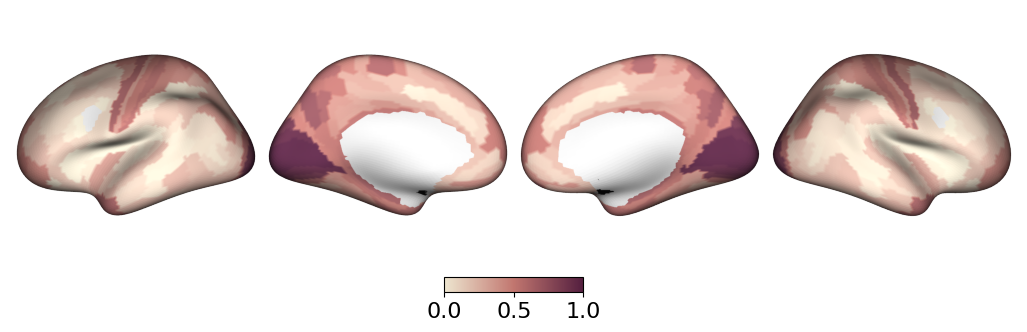

In [24]:
from palettable.cartocolors.sequential import BrwnYl_3
# from palettable.colorbrewer.sequential import
color=BrwnYl_3.mpl_colormap
# Visualize and save as figures

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, layout='row', brightness=.8, mirror_views=True)
#p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)

#p.add_layer(diff_cortex, cmap=color, cbar=True, color_range=[0,1])
#p.add_layer(Geodesic_cortex, cmap=color, cbar=True, color_range=[0,1])
#p.add_layer(fiberLength_cortex, cmap='hot_r', cbar=True, color_range=[0,1])
p.add_layer(wiringCost_cortex, cmap=color, cbar=True, color_range=[0,1])
#p.add_layer(Myelin_cortex, cmap='Spectral_r', cbar=True, color_range=[0,1])
#p.add_layer(Aghourian_cortex, cmap='cool', cbar=True, color_range=[0,1])
#p.add_layer(Bedard_cortex, cmap='cool', cbar=True, color_range=[0,1])
#p.add_layer(Tuominen_cortex, cmap='cool', cbar=True, color_range=[0,1])
#p.add_layer(MicCorr_cortex, cmap='cool', cbar=True, color_range=[0,1])
#p.add_layer(wresid_cortex, cmap='Spectral_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
#fig.savefig(fig_path+'parc-scaled_GeodesicDistance_inflated_row.png', dpi=300, transparent=True)

### color bar

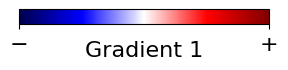

In [85]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='seismic'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Gradient 1", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['−','+'], fontsize=16)
plt.savefig(fig_path+f'Gradient1_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

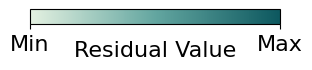

In [86]:
from palettable.cartocolors.sequential import Mint_3
# from palettable.colorbrewer.sequential import
color=Mint_3.mpl_colormap
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=color), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Residual Value", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'Residual_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

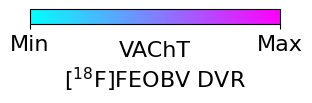

In [146]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='cool'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label("VAChT\n[$^{18}$F]FEOBV DVR", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'VAChT_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

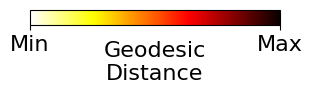

In [140]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='hot_r'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Geodesic\nDistance", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'GeodesicDist_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

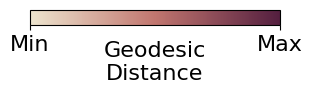

In [57]:
from palettable.cartocolors.sequential import BrwnYl_3
# from palettable.colorbrewer.sequential import
color=BrwnYl_3.mpl_colormap
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=color), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Geodesic\nDistance", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'GeodesicDistance_BrwnYl-bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

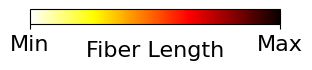

In [30]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='hot_r'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Fiber Length", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'FiberLength_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

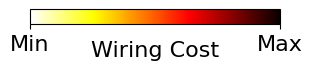

In [25]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='hot_r'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Wiring Cost", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'WiringCost_hot-r_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

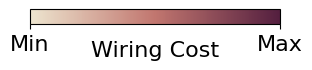

In [31]:
from palettable.cartocolors.sequential import BrwnYl_3
# from palettable.colorbrewer.sequential import
color=BrwnYl_3.mpl_colormap
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=color), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Wiring Cost", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'WiringCost_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

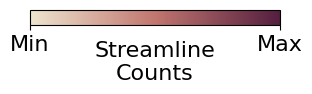

In [12]:
from palettable.cartocolors.sequential import BrwnYl_3
# from palettable.colorbrewer.sequential import
color=BrwnYl_3.mpl_colormap
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=color), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Streamline\nCounts", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'StreamlineCounts_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

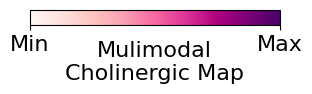

In [128]:
import matplotlib
fig = plt.figure(figsize=(5,5))
norm = matplotlib.colors.Normalize(-1, 1)
cb_ax = fig.add_axes([0.25, 0.25, 0.5, 0.03]) # start x, start y, length x, height y
cb = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='RdPu'), 
                  ticks=[-1, 1], cax=cb_ax, orientation='horizontal')
cb.set_label(f"Mulimodal\nCholinergic Map", fontsize=16, labelpad=-10)
cb.ax.set_xticklabels(['Min','Max'], fontsize=16)
plt.savefig(fig_path+f'Summary_bar.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

#### Combine cortical maps

In [45]:
Geodesic_parc_scaled_data = parc_rescaled['Geodesic'].values
Myelin_parc_scaled_data = parc_rescaled['Myelin'].values
MicCorr_parc_scaled_data = parc_rescaled['Michigan_FEOBV'].values
wresid_parc_scaled_data = parc_rescaled['wresidC'].values
G1sresidC_parc = parc_rescaled['G1residC'].values

In [46]:
MicCorr_cortex = map_to_labels(MicCorr_parc_scaled_data.reshape([360]),surf_labels, mask=mask, fill=np.nan)
wresid_cortex = map_to_labels(wresid_parc, surf_labels, mask=mask, fill=np.nan)

In [47]:
G1residC_cortex = map_to_labels(G1sresidC_parc.reshape([360]), surf_labels, mask=mask, fill=np.nan)

In [93]:
Inverted_Geodesic_cortex = map_to_labels((1-Geodesic_parc_scaled_data.reshape([360])),surf_labels, mask=mask, fill=np.nan)
Inverted_Myelin_cortex = map_to_labels((1-Myelin_parc_scaled_data.reshape([360])),surf_labels, mask=mask, fill=np.nan)

In [94]:
Com_wresid_Mic_InvGeo_cortex = np.mean([wresid_cortex,MicCorr_cortex,Inverted_Geodesic_cortex], axis=0)

In [99]:
Com_G1resid_Mic_InvGeo_cortex = np.mean([G1residC_cortex,MicCorr_cortex,Inverted_Geodesic_cortex], axis=0)

In [95]:
Com_wresid_Mic_InvGeo_InvMye_cortex = np.mean([wresid_cortex,MicCorr_cortex,Inverted_Geodesic_cortex,Inverted_Myelin_cortex], axis=0)

In [44]:
Inverted_FiberLength_cortex = map_to_labels((1-fiberLength_parc),surf_labels, mask=mask, fill=np.nan)

In [48]:
Com_G1resid_Mic_InvFL_cortex = np.mean([G1residC_cortex,MicCorr_cortex,Inverted_FiberLength_cortex], axis=0)

In [50]:
Com_G1resid_Mic_InvFL_cortex.shape

(20484,)

In [62]:
np.nanmax(Com_wresid_Mic_InvGeo_cortex)

0.8401879286346435

In [16]:
Com_wresid_Mic_InvGeo_cortex.shape

(20484,)

/tmp/ipykernel_202771/1386655471.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


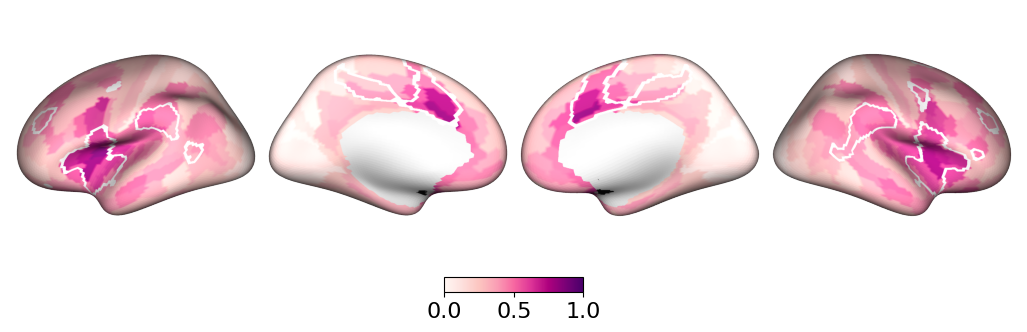

In [54]:
# Visualize and save as figures

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, layout='row', brightness=.8, mirror_views=True)

#p.add_layer(Inverted_Geodesic_cortex, cmap='hot_r', cbar=True, color_range=[0,1])
#p.add_layer(Inverted_Myelin_cortex, cmap='Spectral_r', cbar=True, color_range=[0,1])
#p.add_layer(MicCorr_cortex, cmap='cool', cbar=True, color_range=[0,1])
#p.add_layer(wresid_cortex, cmap='Spectral_r', cbar=True, color_range=[0,1])
#p.add_layer(Com_wresid_Mic_InvGeo_cortex, cmap='RdPu', cbar=True, color_range=[0,1])
#p.add_layer(Com_G1resid_Mic_InvGeo_cortex, cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(Com_G1resid_Mic_InvFL_cortex, cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(va_network, cmap='gray', as_outline=True, cbar=False)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
fig.savefig(fig_path+'parc-scaled_Com-G1resid-Mic-InvFL-map_inflated_RdPu-VAline.png', dpi=300, transparent=True)

#### Save as Gifti

In [139]:
# Geodeseic
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Geodesic_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Geodesic-dist_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Geodesic_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Geodesic-dist_R_fsa-10k.shape.gii')

In [140]:
# Myelin
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Myelin_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Myelin-map_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Myelin_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Myelin-map_R_fsa-10k.shape.gii')

In [141]:
# Michigan FEOBV
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(MicCorr_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Michigan-FEOBV_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(MicCorr_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Michigan-FEOBV_R_fsa-10k.shape.gii')

In [142]:
# Residual
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(wresid_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Residual-map_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(wresid_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Residual-map_R_fsa-10k.shape.gii')

In [68]:
# Com_wresid_Mic_InvGeo_cortex
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Com_wresid_Mic_InvGeo_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-map_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Com_wresid_Mic_InvGeo_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-map_R_fsa-10k.shape.gii')

In [70]:
# Com_wresid_Mic_InvGeo_InvMye_cortex
gii_L = nib.gifti.GiftiImage()
gii_L.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Com_wresid_Mic_InvGeo_InvMye_cortex[:10242].astype(np.float32))) # For left hemisphere
nib.save(gii_L, results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-InvMye-map_L_fsa-10k.shape.gii')

gii_R = nib.gifti.GiftiImage()
gii_R.add_gifti_data_array(
    nib.gifti.GiftiDataArray(Com_wresid_Mic_InvGeo_InvMye_cortex[10242:].astype(np.float32))) # right hemisphere is [32492:]
nib.save(gii_R, results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-InvMye-map_R_fsa-10k.shape.gii')

#### Visualize Gifti

In [143]:
lh_gii = images.load_gifti(results_path+'Parc-rescaled_Residual-map_L_fsa-10k.shape.gii')
rh_gii = images.load_gifti(results_path+'Parc-rescaled_Residual-map_R_fsa-10k.shape.gii')
lh_data = lh_gii.agg_data()
rh_data = rh_gii.agg_data()
LR_data = np.concatenate((lh_data, rh_data))

/tmp/ipykernel_1389763/340047860.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


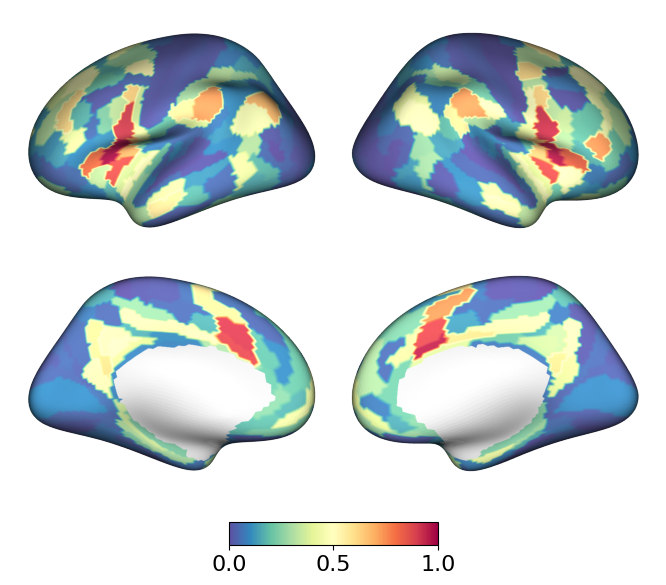

In [145]:
# visualize
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, brightness=.8)

p.add_layer(LR_data, cmap='Spectral_r', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
#fig.savefig(fig_path+'parc-scaled_Residual_inflated_grid_Spectral-r.png', dpi=300)

### Yeo Network for color ref

In [5]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap)

/tmp/ipykernel_22754/4120515300.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


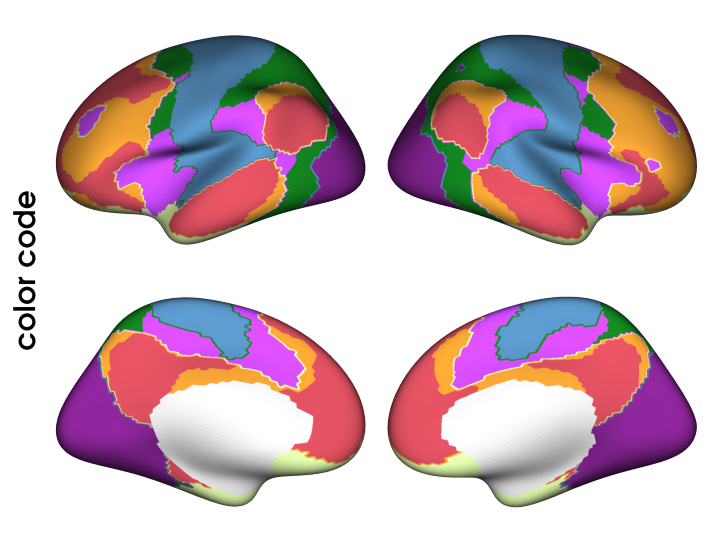

In [9]:
# Visualize network color ref

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
fig = p.build()
fig.show()

In [6]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [7]:
network_parc = hcpmmp.transform(yeo_networks, 'fsaverage', ignore_background_data=True)

In [53]:
# Creating Ventral Attention network only surface projection
va_network = np.zeros(yeo_networks.shape)
va_network[yeo_networks == 4] = 1
vaCols = ListedColormap(yeo_colormap_gray[4])

/tmp/ipykernel_170634/2884710800.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


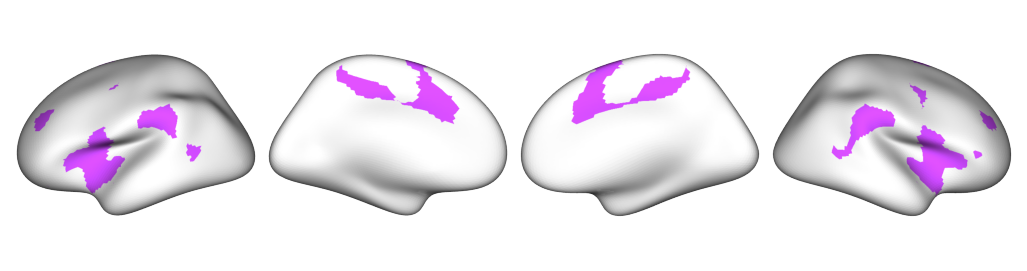

In [77]:
# Visualize network color ref

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, layout='row', brightness=.8, mirror_views=True)
p.add_layer(va_network, cmap=vaCols, cbar=False)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()

### Load and visualize combined (average) data gifti (for Fig.5)

In [84]:
lh_gii = images.load_gifti(results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-InvMye-map_L_fsa-10k.shape.gii')
rh_gii = images.load_gifti(results_path+'Parc-rescaled_Com-wresid-Mic-InvGeo-InvMye-map_R_fsa-10k.shape.gii')
lh_data = lh_gii.agg_data()
rh_data = rh_gii.agg_data()
LR_data = np.concatenate((lh_data, rh_data))

In [59]:
np.nanmin(LR_data)

0.114787

/tmp/ipykernel_170634/3094379726.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


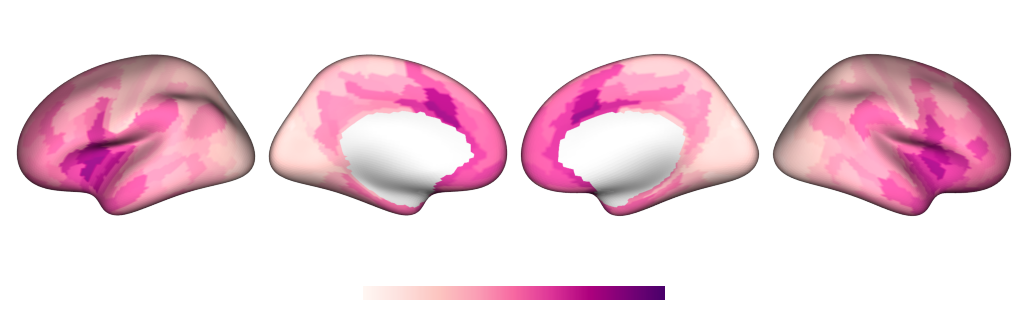

In [85]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh,rh, size=(1200, 300), zoom=1.2, brightness=.8, layout='row', mirror_views=True)

p.add_layer(LR_data, cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
cbar_kws = dict(outer_labels_only=True, location='bottom', n_ticks=0, draw_border=False, aspect=21)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
#fig.savefig(fig_path+'parc-scaled_Com-wresid-Mic-InvGeo-map_inflated_LR_RdPu.png', dpi=300)

#### add the Ventral attention network outline

/tmp/ipykernel_170634/906622511.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


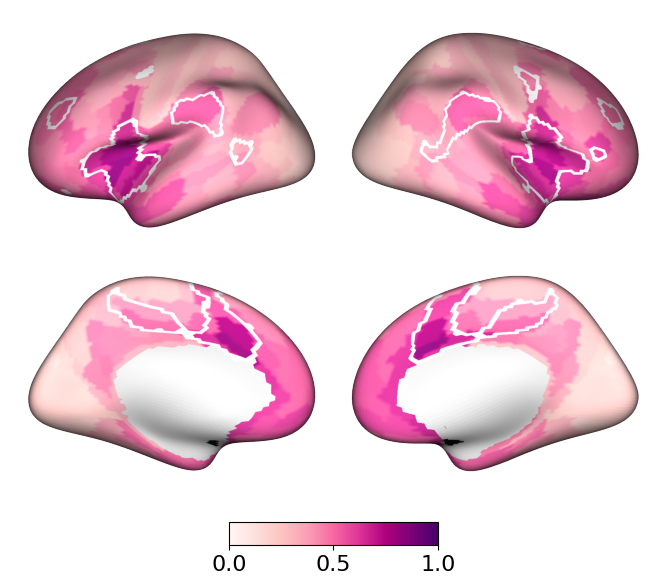

In [86]:
surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

#p = Plot(lh,rh, size=(1200, 300), zoom=1.2, brightness=.8, layout='row', mirror_views=True)
p= Plot(lh, rh, size=(800, 600), brightness=.8)
p.add_layer(LR_data, cmap='RdPu', cbar=True, color_range=[0,1])
p.add_layer(va_network, cmap='gray', as_outline=True, cbar=False)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
cbar_kws = dict(outer_labels_only=True, pad=.05, n_ticks=3, decimals=1, fontsize=16, aspect=9)
fig = p.build(cbar_kws=cbar_kws)
fig.show()
fig.savefig(fig_path+'parc-scaled_Com-wresid-Mic-InvGeo-InvMye-map_VAN-outline_inflated.png', dpi=300)

## Correlations

### Load parc-rescaled data

In [8]:
parc_rescaled = pd.read_csv(results_path + 'parc_rescaled_all_data.csv')

In [9]:
parc_rescaled

Geodesic    Myelin  Michigan_FEOBV  Aghourian_FEOBV  Bedard_FEOBV  \
0    0.718208  0.725158        0.307165         0.284614      0.040923   
1    0.756606  0.635854        0.393784         0.401920      0.107447   
2    0.756608  0.647891        0.341122         0.303877      0.042400   
3    0.719054  0.671180        0.280373         0.227710      0.032227   
4    0.779794  0.632432        0.181810         0.279805      0.076867   
..        ...       ...             ...              ...           ...   
355  0.442331  0.256823        0.554505         0.459290      0.254334   
356  0.560568  0.266042        0.289936         0.372814      0.175223   
357  0.216424  0.161699        0.678257         0.426209      0.311874   
358  0.309827  0.227378        0.695732         0.673738      0.280750   
359  0.199730  0.126194        0.704833         0.711029      0.265630   

     Tuominen_FEOBV  functional  abs_functional  structural   wresidC  \
0          0.196568    0.563640        0.519885    0.805695  0.100994   
1          0.209680    0.164174        0.106873    0.112599  0.050152   
2          0.192183    0.138740        0.103628    0.433660  0.051173   
3          0.171076    0.377697        0.316383    0.731491  0.044553   
4          0.147329    0.315332        0.253073    0.684552  0.026488   
..              ...         ...             ...         ...       ...   
355        0.247783    0.595161        0.571793    0.202580  0.426654   
356        0.167511    0.549909        0.511467    0.163962  0.110377   
357        0.437831    0.547436        0.522263    0.294434  0.317268   
358        0.338893    0.557818        0.535859    0.181482  0.411807   
359        0.516453    0.747320        0.721977    0.591108  0.216542   

     G1residC  unwresidC  FiberLength  WiringCost  
0    0.062583   0.105678     0.926806    1.000000  
1    0.037691   0.050892     0.297932    0.044925  
2    0.023673   0.053624     0.858001    0.498284  
3    0.025218   0.046576     0.967830    0.948087  
4    0.010557   0.028410     0.960529    0.880557  
..        ...        ...          ...         ...  
355  0.414489   0.423854     0.438825    0.119050  
356  0.106708   0.109670     0.408750    0.089751  
357  0.289798   0.316929     0.498011    0.196367  
358  0.380788   0.405176     0.378452    0.091978  
359  0.265091   0.203328     0.386781    0.306177  

[360 rows x 14 columns]

In [10]:
geodesic_parc = parc_rescaled['Geodesic'].values
myelin_parc = parc_rescaled['Myelin'].values

MicCorr_parc = parc_rescaled['Michigan_FEOBV'].values
Aghourian_parc = parc_rescaled['Aghourian_FEOBV'].values
Bedard_parc = parc_rescaled['Bedard_FEOBV'].values
Tuominen_parc = parc_rescaled['Tuominen_FEOBV'].values

func_parc = parc_rescaled['functional'].values
diff_parc = parc_rescaled['structural'].values

wresid_parc = parc_rescaled['wresidC'].values

In [11]:
abs_func_parc = parc_rescaled['abs_functional'].values
G1sresidC_parc = parc_rescaled['G1residC'].values
unwresidC_parc = parc_rescaled['unwresidC'].values

In [12]:
fiberLength_parc = parc_rescaled['FiberLength'].values
wiringCost_parc = parc_rescaled['WiringCost'].values

In [13]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

### Scatter plots

#### Wiring cost x connectivity data

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


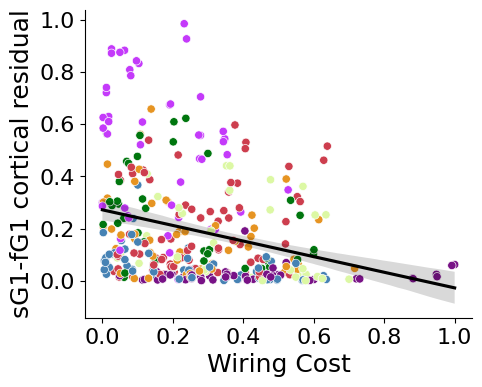

In [36]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(wiringCost_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Wiring Cost',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=wiringCost_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_wiringCost_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


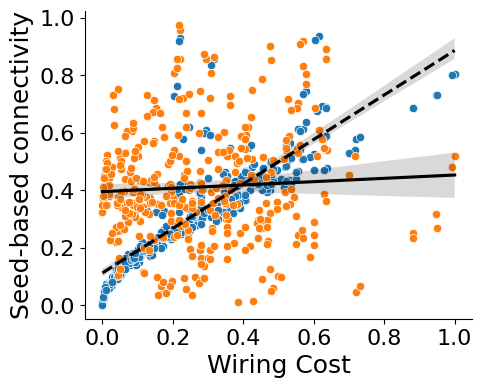

In [38]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,4))

ax = sns.scatterplot(wiringCost_parc, diff_parc)#, hue=network_parc, palette=yeoCols, marker='x')
ax = sns.scatterplot(wiringCost_parc, abs_func_parc)#, hue=network_parc, palette=yeoCols)
ax.legend([],[], frameon=False)
ax.set_xlabel('Wiring Cost', fontsize=18)
ax.set_ylabel('Seed-based connectivity', fontsize=18)

# Add fit line
sns.regplot(
    x=wiringCost_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

sns.regplot(
    x=wiringCost_parc,
    y=abs_func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

#custom = [Line2D([], [], marker='o', markerfacecolor='#ff7f0e', linestyle='-', color='black'),
          #Line2D([], [], marker='o', markerfacecolor='#1f77b4', linestyle='--', color='black')]

#fig.legend(custom, ['Functional','Structural'], fontsize=16, loc='center right', bbox_to_anchor=(1.1, 0.2))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_wiringCost_vs_StrucFunc_Connectivity_no-legend.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### Fiber Length x connectivity data

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


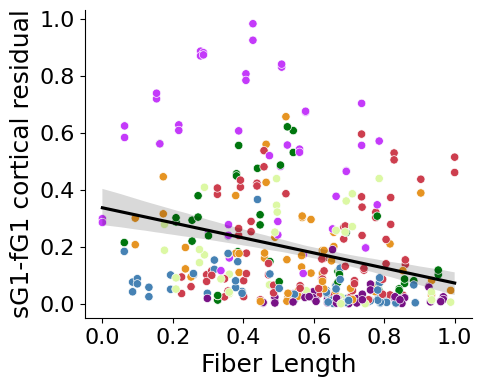

In [16]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(fiberLength_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Fiber Length',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=fiberLength_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_fiberLength_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


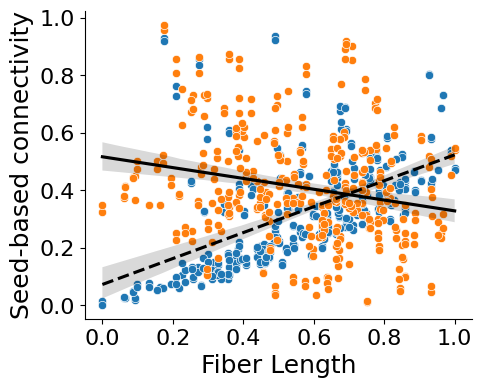

In [17]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,4))

ax = sns.scatterplot(fiberLength_parc, diff_parc)#, hue=network_parc, palette=yeoCols, marker='x')
ax = sns.scatterplot(fiberLength_parc, abs_func_parc)#, hue=network_parc, palette=yeoCols)
ax.legend([],[], frameon=False)
ax.set_xlabel('Fiber Length', fontsize=18)
ax.set_ylabel('Seed-based connectivity', fontsize=18)

# Add fit line
sns.regplot(
    x=fiberLength_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

sns.regplot(
    x=fiberLength_parc,
    y=abs_func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

#custom = [Line2D([], [], marker='o', markerfacecolor='#ff7f0e', linestyle='-', color='black'),
          #Line2D([], [], marker='o', markerfacecolor='#1f77b4', linestyle='--', color='black')]

#fig.legend(custom, ['Functional','Structural'], fontsize=16, loc='center right', bbox_to_anchor=(1.1, 0.2))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_fiberLength_vs_StrucFunc_Connectivity_no-legend.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


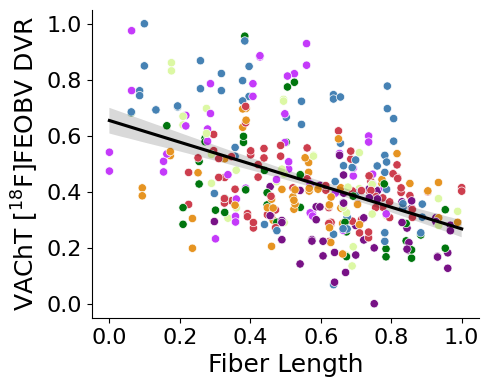

In [24]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(fiberLength_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Fiber Length',  fontsize=18)
ax1.set_ylabel('VAChT [$^{18}$F]FEOBV DVR', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=fiberLength_parc,
    y=MicCorr_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_fiberLength_vs_MicCorr_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### Geodesic x connectivity data

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


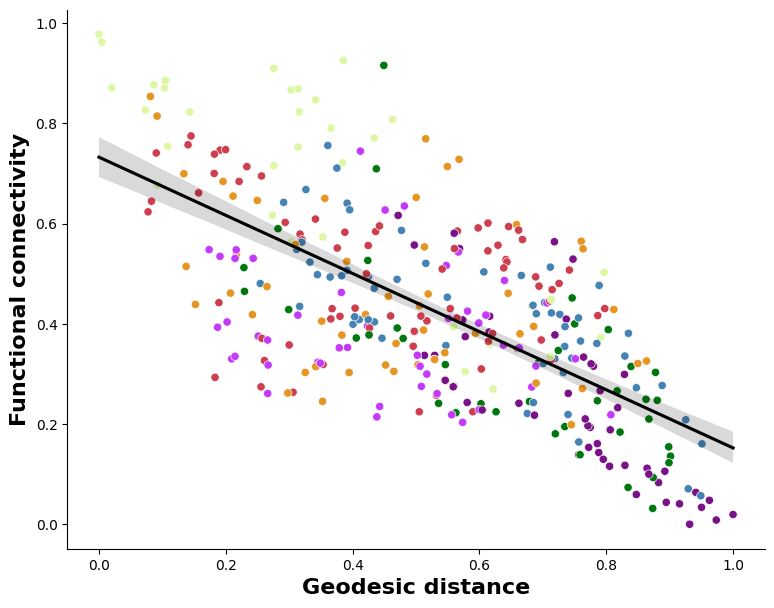

In [180]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


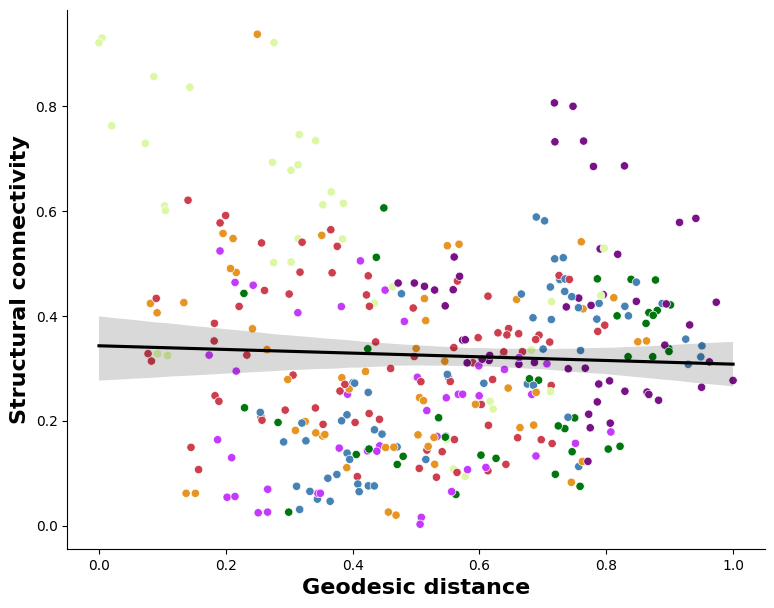

In [181]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


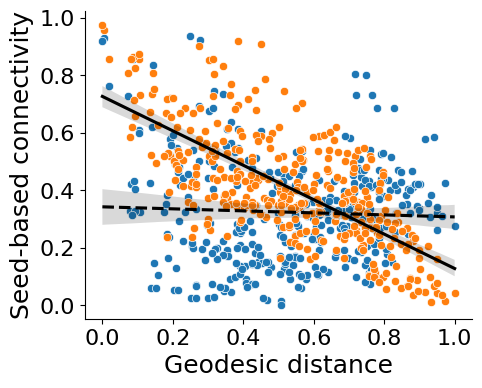

In [81]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,4))

ax = sns.scatterplot(geodesic_parc, diff_parc)#, hue=network_parc, palette=yeoCols, marker='x')
ax = sns.scatterplot(geodesic_parc, abs_func_parc)#, hue=network_parc, palette=yeoCols)
ax.legend([],[], frameon=False)
ax.set_xlabel('Geodesic distance', fontsize=18)
ax.set_ylabel('Seed-based connectivity', fontsize=18)

# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

sns.regplot(
    x=geodesic_parc,
    y=abs_func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

#custom = [Line2D([], [], marker='o', markerfacecolor='#ff7f0e', linestyle='-', color='black'),
          #Line2D([], [], marker='o', markerfacecolor='#1f77b4', linestyle='--', color='black')]

#fig.legend(custom, ['Functional','Structural'], fontsize=16, loc='center right', bbox_to_anchor=(1.1, 0.2))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_StrucFunc_Connectivity_no-legend.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### Geodesic x VAChT

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


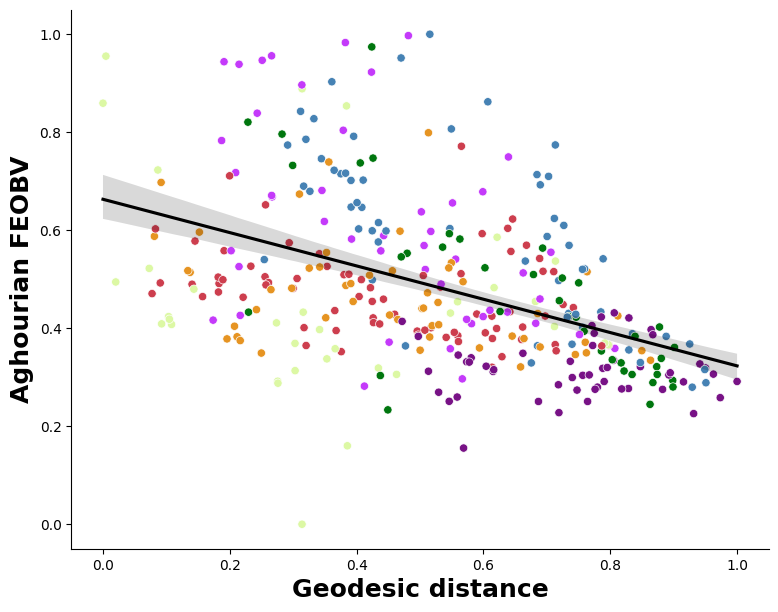

In [194]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Aghourian_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Aghourian_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Aghourian_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


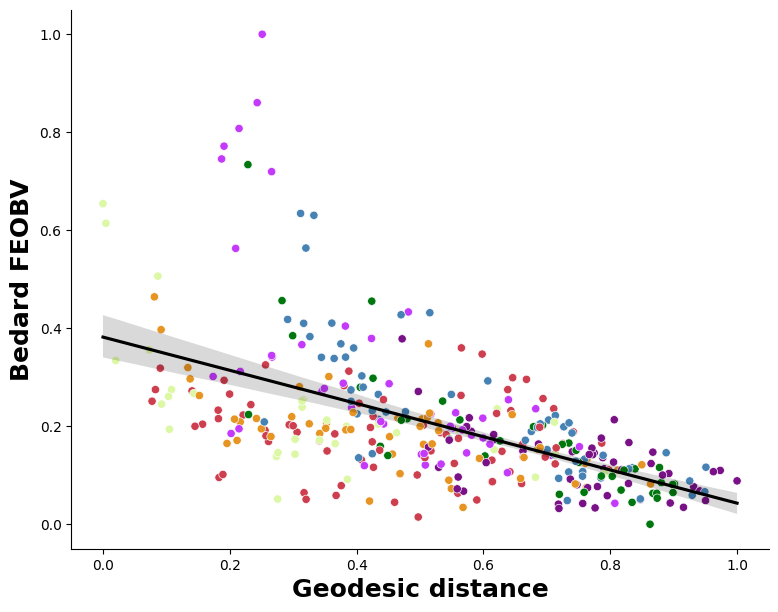

In [195]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Bedard_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Bedard_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Bedard_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


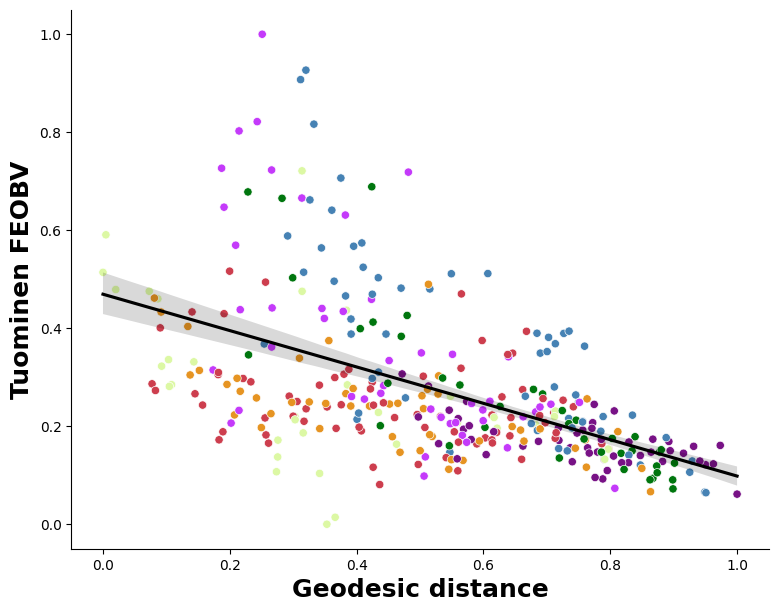

In [197]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=18)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=Tuominen_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Tuominen_FEOBV.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


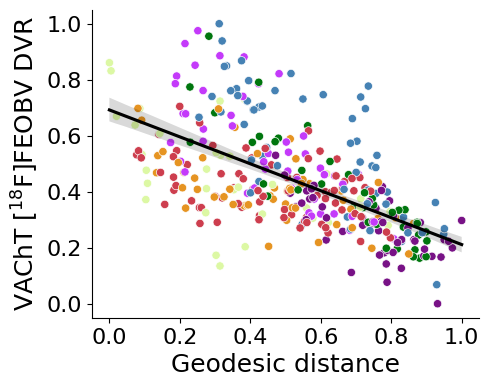

In [132]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(geodesic_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', fontsize=18)
ax1.set_ylabel('VAChT [$^{18}$F]FEOBV DVR', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Tuominen_FEOBV", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=MicCorr_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Michigan-Corrected_FEOBV.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### SG1-fG1 cortical residual 

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


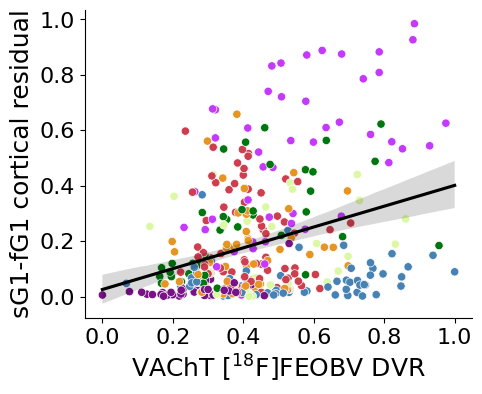

In [37]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(MicCorr_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('VAChT [$^{18}$F]FEOBV DVR',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=MicCorr_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_MichiganCorr_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


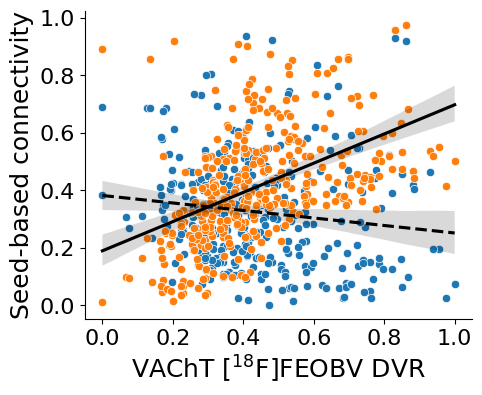

In [134]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(5,4))

ax = sns.scatterplot(MicCorr_parc, diff_parc)#, hue=network_parc, palette=yeoCols, marker='x')
ax = sns.scatterplot(MicCorr_parc, abs_func_parc)#, hue=network_parc, palette=yeoCols)
ax.legend([],[], frameon=False)
ax.set_xlabel('VAChT [$^{18}$F]FEOBV DVR', fontsize=18)
ax.set_ylabel('Seed-based connectivity', fontsize=18)

# Add fit line
sns.regplot(
    x=MicCorr_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black', 'ls':'--'},
    ax=ax)
sns.despine()

sns.regplot(
    x=MicCorr_parc,
    y=abs_func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax)
sns.despine()

#custom = [Line2D([], [], marker='o', markerfacecolor='#ff7f0e', linestyle='-', color='black'),
          #Line2D([], [], marker='o', markerfacecolor='#1f77b4', linestyle='--', color='black')]

#fig.legend(custom, ['Functional','Structural'], fontsize=16, loc='center right', bbox_to_anchor=(1.1, 0.2))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_VAChT_vs_StrucFunc_Connectivity_no-legend.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


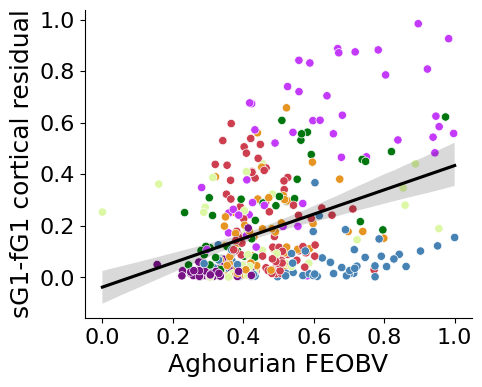

In [14]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(Aghourian_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Aghourian FEOBV',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=Aghourian_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_AghourianFEOBV_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


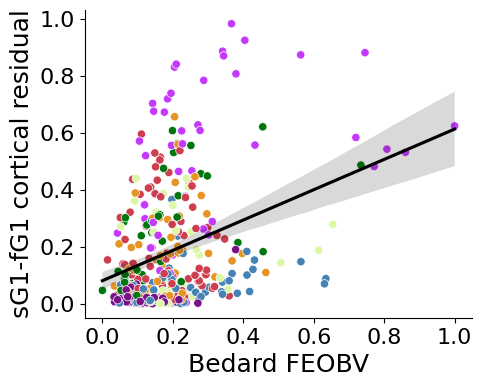

In [17]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(Bedard_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Bedard FEOBV',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=Bedard_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_BedardFEOBV_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


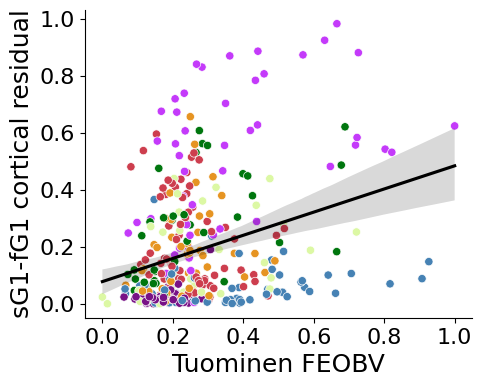

In [18]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(5,4))

ax1 = sns.scatterplot(Tuominen_parc, G1sresidC_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Tuominen FEOBV',  fontsize=18)
ax1.set_ylabel('sG1-fG1 cortical residual', fontsize=18)
#ax1.axes.set_ylim(0, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=Tuominen_parc,
    y=G1sresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(fig_path + f'Parcellated_TuominenFEOBV_vs_sG1-fG1_cortical-residual.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

#### weighted gradient-weighted average cortical residual 

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


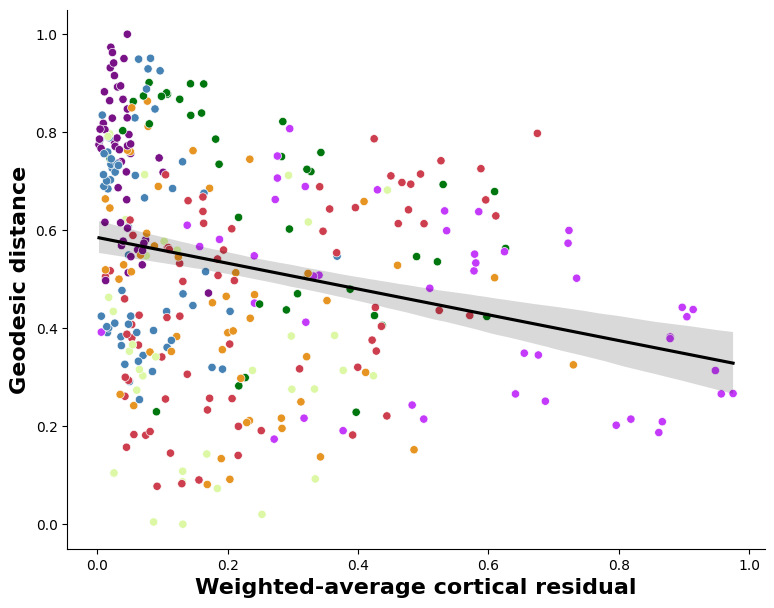

In [183]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, geodesic_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=geodesic_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


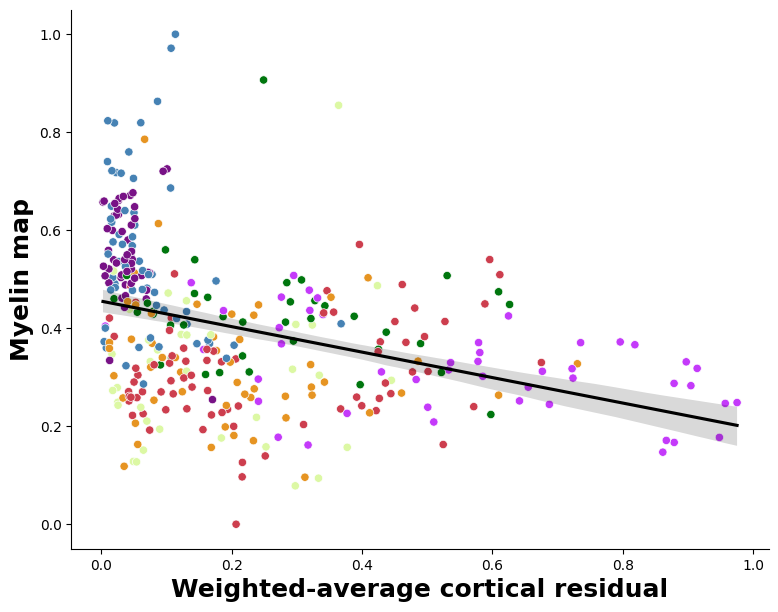

In [185]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresidC_parc, myelin_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Myelin map', weight='bold', fontsize=18)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0.5, 1.0)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=myelin_parc,
    x=wresidC_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin-map-asY_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


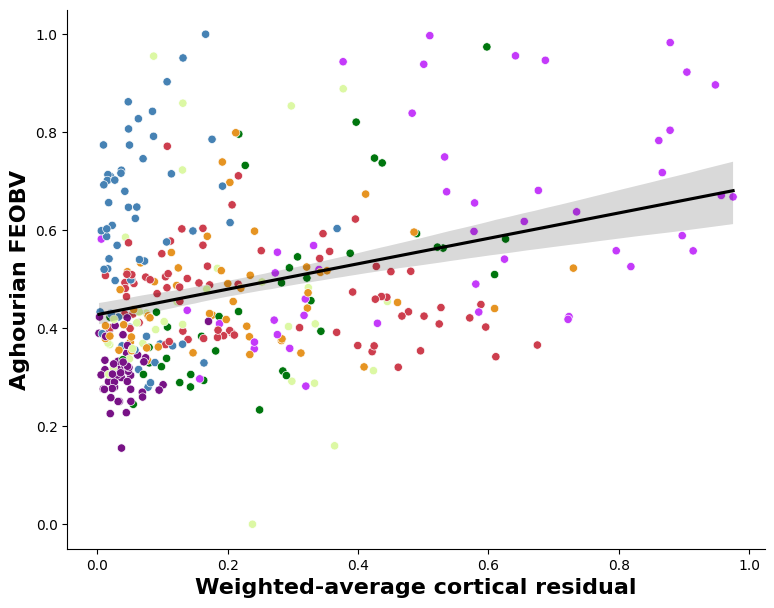

In [187]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Aghourian_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Aghourian FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
#ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Aghourian_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Aghourian_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


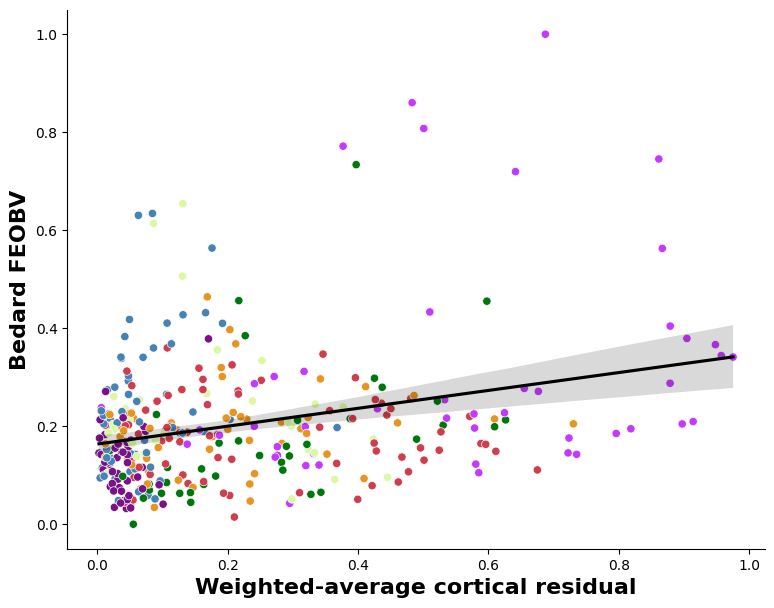

In [188]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Bedard_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Bedard FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
#ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Bedard_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Bedard_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


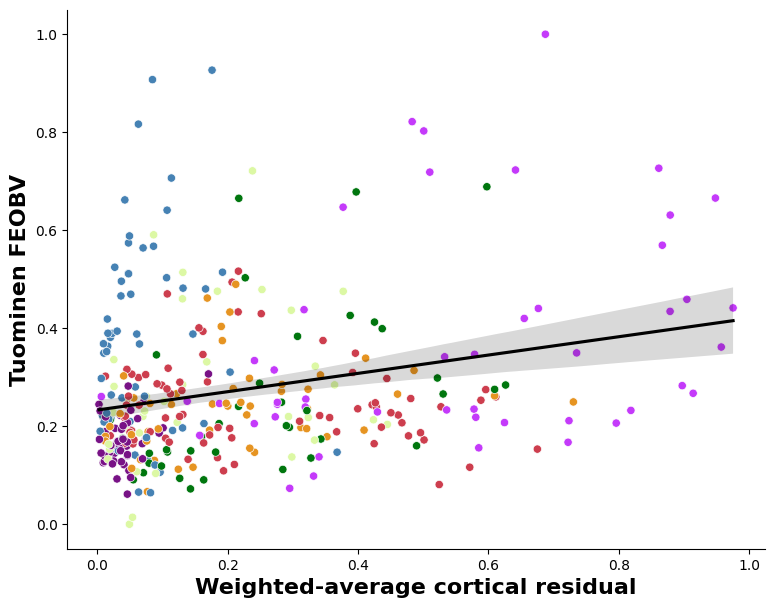

In [189]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, Tuominen_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Tuominen FEOBV', weight='bold', fontsize=16)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=16)
#ax1.axes.set_ylim(0, 0.7)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=Tuominen_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Tuominen_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


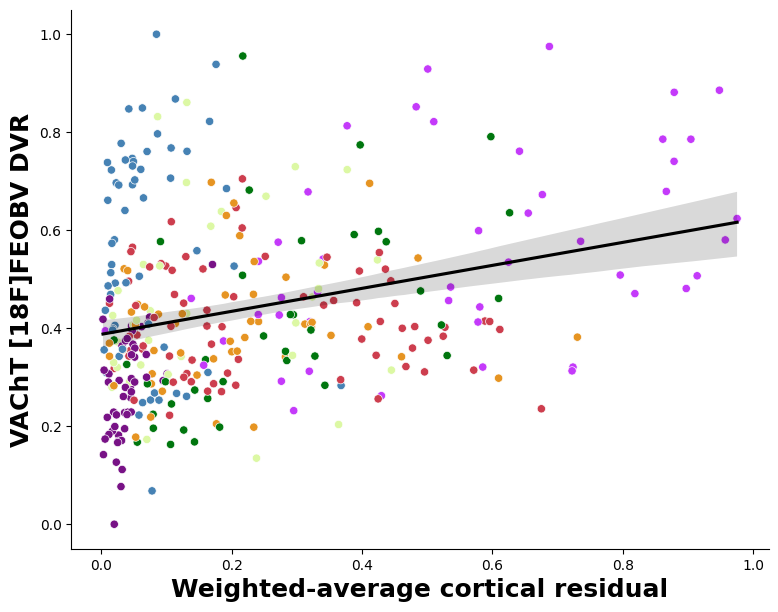

In [99]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(wresid_parc, MicCorr_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('VAChT [18F]FEOBV DVR', weight='bold', fontsize=18)
ax1.set_xlabel('Weighted-average cortical residual', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    y=MicCorr_parc,
    x=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_MichiganCorr_vs_Weighted-average_cortical-residual.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


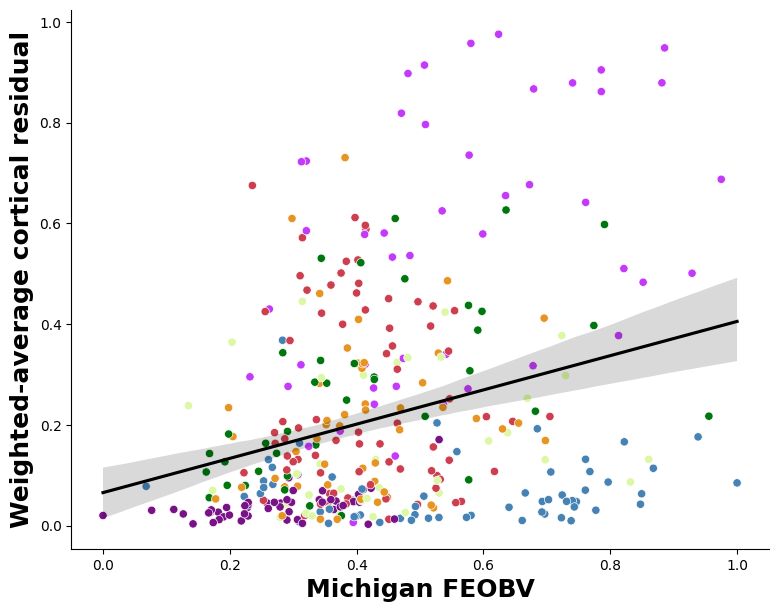

In [15]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(MicCorr_parc, wresid_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Michigan FEOBV', weight='bold', fontsize=18)
ax1.set_ylabel('Weighted-average cortical residual', weight='bold', fontsize=18)
#ax1.axes.set_ylim(0, 0.7)
#ax1.axes.set_xlim(0, 1.0)

#plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=MicCorr_parc,
    y=wresid_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_MichiganCorr_vs_Weighted-average_cortical-residual-x-Mic.png', dpi=300, bbox_inches='tight')

plt.show()

#### Myelin map

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


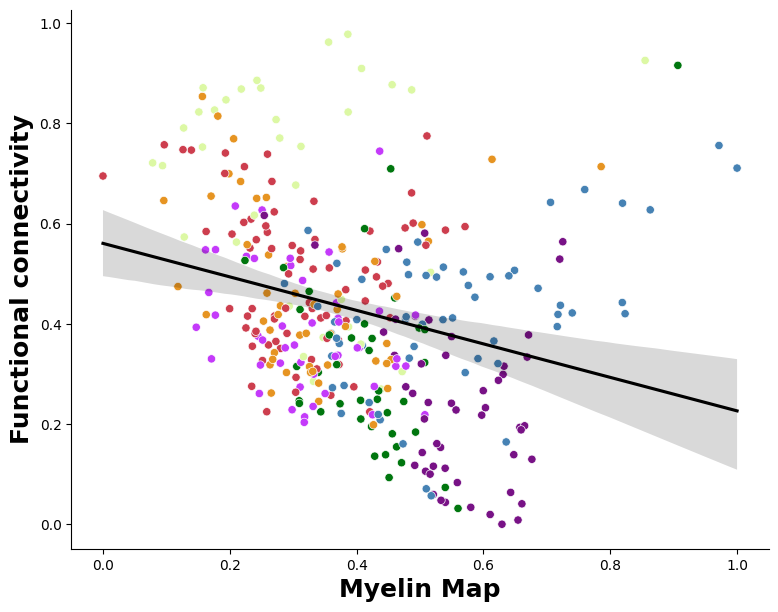

In [199]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=18)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=18)

#plt.title("Myelin map vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


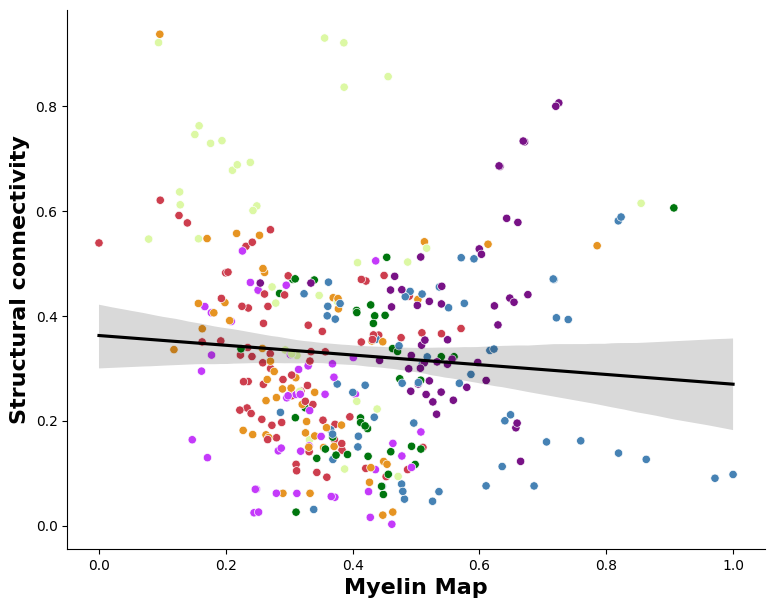

In [200]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)

#plt.title("Myelin map vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


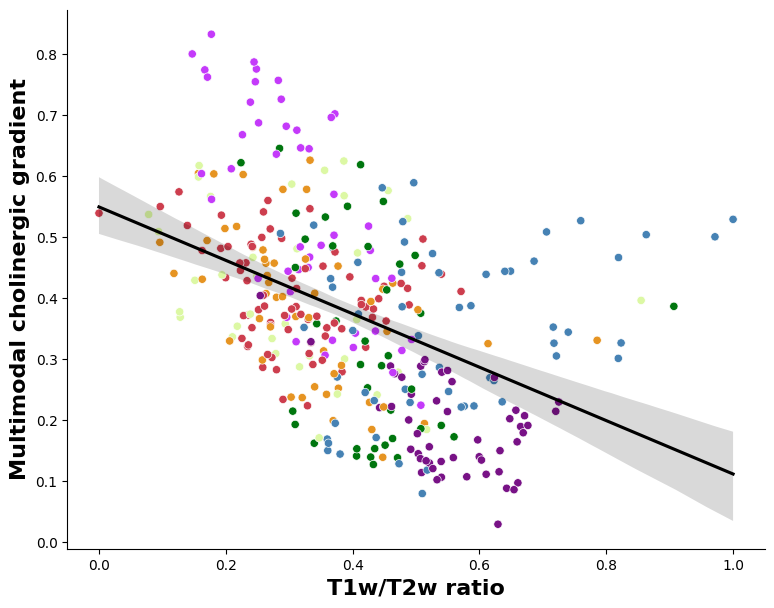

In [217]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, Com_wresid_Mic_InvGeo_parc.reshape([360]), hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('T1w/T2w ratio', weight='bold', fontsize=16)
ax1.set_ylabel('Multimodal cholinergic gradient', weight='bold', fontsize=16)

#plt.title("Myelin map vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=Com_wresid_Mic_InvGeo_parc.reshape([360]),
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Multimodal-BF-grad.png', dpi=300, bbox_inches='tight')

plt.show()

### Null model spin tests

In [18]:
# set #permutations
n_perm = 10000

#### Geodesic Distance x Connectivity, residual, VAChT

In [88]:
geodesic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                              n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [203]:
pc_fcgc_corr, pc_fcgc_pval = stats.compare_images(geodesic_parc,func_parc, nulls=geodesic_parc_rotated)
pc_fcgc_corr, pc_fcgc_pval

(-0.6732260079798236, 0.0110988901109889)

In [89]:
#abs functional
pc_fcgc_corr, pc_fcgc_pval = stats.compare_images(geodesic_parc,abs_func_parc, nulls=geodesic_parc_rotated)
pc_fcgc_corr, pc_fcgc_pval

(-0.7043050885227808, 0.0051994800519948)

In [147]:
pc_dcgc_corr, pc_dcgc_pval = stats.compare_images(geodesic_parc,diff_parc, nulls=geodesic_parc_rotated)
pc_dcgc_corr, pc_dcgc_pval

(-0.04360722238889579, 0.9173082691730827)

In [205]:
pc_wrc_corr, pc_wrc_pval = stats.compare_images(geodesic_parc,wresid_parc, nulls=geodesic_parc_rotated)
pc_wrc_corr, pc_wrc_pval

(-0.25277045474368093, 0.18118188181181882)

In [206]:
pc_afgc_corr, pc_afgc_pval = stats.compare_images(geodesic_parc, Aghourian_parc, nulls=geodesic_parc_rotated)
pc_afgc_corr, pc_afgc_pval

(-0.45276868849469554, 0.08039196080391961)

In [207]:
pc_bfgc_corr, pc_bfgc_pval = stats.compare_images(geodesic_parc, Bedard_parc, nulls=geodesic_parc_rotated)
pc_bfgc_corr, pc_bfgc_pval

(-0.565837811586656, 0.0045995400459954)

In [208]:
pc_tfgc_corr, pc_tfgc_pval = stats.compare_images(geodesic_parc, Tuominen_parc, nulls=geodesic_parc_rotated)
pc_tfgc_corr, pc_tfgc_pval

(-0.5316783722465329, 0.00029997000299970003)

In [209]:
pc_mcgc_corr, pc_mcgc_pval = stats.compare_images(geodesic_parc, MicCorr_parc, nulls=geodesic_parc_rotated)
pc_mcgc_corr, pc_mcgc_pval

(-0.6021886346812791, 0.00029997000299970003)

In [71]:
pc_gdg1rc_corr, pc_gdg1rc_pval = stats.compare_images(geodesic_parc, G1sresidC_parc, nulls=geodesic_parc_rotated)
print("Geodesic distance vs. sG1-fG1 cortical residuals corr=",pc_gdg1rc_corr," pval=",pc_gdg1rc_pval)

Geodesic distance vs. sG1-fG1 cortical residuals corr= -0.2622277582505077  pval= 0.15878412158784122


In [72]:
pc_uwrgd_corr, pc_uwrgd_pval = stats.compare_images(geodesic_parc, unwresidC_parc, nulls=geodesic_parc_rotated)
print("Geodesic distance vs. unweighted cortical residuals corr=", pc_uwrgd_corr," pval=",pc_uwrgd_pval)

Geodesic distance vs. unweighted cortical residuals corr= -0.2507317439938634  pval= 0.18548145185481452


In [73]:
pc_wrgd_corr, pc_wrgd_pval = stats.compare_images(geodesic_parc, wresid_parc, nulls=geodesic_parc_rotated)
print("Geodesic distance vs. variance weighted cortical residuals corr=",pc_wrgd_corr," pval=",pc_wrgd_pval)

Geodesic distance vs. variance weighted cortical residuals corr= -0.25277045474368093  pval= 0.18118188181181882


In [74]:
print("Geodesic distance vs. sG1-fG1 cortical residuals corr=",pc_gdg1rc_corr," pval=",pc_gdg1rc_pval)
print("Geodesic distance vs. unweighted cortical residuals corr=", pc_uwrgd_corr," pval=",pc_uwrgd_pval)
print("Geodesic distance vs. variance weighted cortical residuals corr=",pc_wrgd_corr," pval=",pc_wrgd_pval)

Geodesic distance vs. sG1-fG1 cortical residuals corr= -0.2622277582505077  pval= 0.15878412158784122
Geodesic distance vs. unweighted cortical residuals corr= -0.2507317439938634  pval= 0.18548145185481452
Geodesic distance vs. variance weighted cortical residuals corr= -0.25277045474368093  pval= 0.18118188181181882


#### weighted cortical residual map x VAChT

In [210]:
# Parcellated data spin test
wresid_parc_rotated = nulls.alexander_bloch(wresid_parc, atlas='fsaverage', density='10k',
                                            n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [211]:
pc_afwc_corr, pc_afwc_pval = stats.compare_images(wresid_parc, Aghourian_parc_scaled_data, nulls=wresid_parc_rotated)
pc_afwc_corr, pc_afwc_pval

(0.33188248443324736, 0.0024997500249975004)

In [212]:
pc_bfwc_corr, pc_bfwc_pval = stats.compare_images(wresid_parc, Bedard_parc_scaled_data, nulls=wresid_parc_rotated)
pc_bfwc_corr, pc_bfwc_pval

(0.2926712971049466, 0.012798720127987202)

In [213]:
pc_tfwc_corr, pc_tfwc_pval = stats.compare_images(wresid_parc, Tuominen_parc_scaled_data, nulls=wresid_parc_rotated)
pc_tfwc_corr, pc_tfwc_pval

(0.25738303634020093, 0.0287971202879712)

In [214]:
pc_mcwc_corr, pc_mcwc_pval = stats.compare_images(wresid_parc, MicCorr_parc_scaled_data, nulls=wresid_parc_rotated)
pc_mcwc_corr, pc_mcwc_pval

(0.2822861263129349, 0.019698030196980302)

#### Myelin map x connectivity, wresid data

In [63]:
myelin_parc_rotated = nulls.alexander_bloch(myelin_parc, atlas='fsaverage', density='10k',
                                            n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [216]:
pc_fcmc_corr, pc_fcmc_pval = stats.compare_images(myelin_parc,func_parc, nulls=myelin_parc_rotated)
pc_fcmc_corr, pc_fcmc_pval

(-0.2734865763569099, 0.1743825617438256)

In [217]:
pc_dcmc_corr, pc_dcmc_pval = stats.compare_images(myelin_parc,diff_parc, nulls=myelin_parc_rotated)
pc_dcmc_corr, pc_dcmc_pval

(-0.08161628467923233, 0.6688331166883311)

In [218]:
pc_wrmc_corr, pc_wrmc_pval = stats.compare_images(myelin_parc,wresid_parc, nulls=myelin_parc_rotated)
pc_wrmc_corr, pc_wrmc_pval

(-0.3514504142170131, 0.0014998500149985001)

In [24]:
pc_cmmc_corr, pc_cmmc_pval = stats.compare_images(myelin_parc,Com_wresid_Mic_InvGeo_parc.reshape([360]), nulls=myelin_parc_rotated)
pc_cmmc_corr, pc_cmmc_pval

(-0.4489490544171936, 0.036896310368963105)

In [65]:
pc_mcg1rc_corr, pc_mcg1rc_pval = stats.compare_images(myelin_parc, G1sresidC_parc, nulls=myelin_parc_rotated)
print("Myelin vs. sG1-fG1 cortical residuals corr=",pc_mcg1rc_corr," pval=",pc_mcg1rc_pval)

Myelin vs. sG1-fG1 cortical residuals corr= -0.3351963890315173  pval= 0.004399560043995601


In [68]:
pc_uwrmc_corr, pc_uwrmc_pval = stats.compare_images(myelin_parc,unwresidC_parc, nulls=myelin_parc_rotated)
print("Myelin vs. unweighted cortical residuals corr=", pc_uwrmc_corr," pval=",pc_uwrmc_pval)

Myelin vs. unweighted cortical residuals corr= -0.35008364929620295  pval= 0.0014998500149985001


In [70]:
pc_wrmc_corr, pc_wrmc_pval = stats.compare_images(myelin_parc,wresid_parc, nulls=myelin_parc_rotated)
print("Myelin vs. variance weighted cortical residuals corr=",pc_wrmc_corr," pval=",pc_wrmc_pval)

Myelin vs. variance weighted cortical residuals corr= -0.3514504142170131  pval= 0.0014998500149985001


In [75]:
print("Myelin vs. sG1-fG1 cortical residuals corr=",pc_mcg1rc_corr," pval=",pc_mcg1rc_pval)
print("Myelin vs. unweighted cortical residuals corr=", pc_uwrmc_corr," pval=",pc_uwrmc_pval)
print("Myelin vs. variance weighted cortical residuals corr=",pc_wrmc_corr," pval=",pc_wrmc_pval)

Myelin vs. sG1-fG1 cortical residuals corr= -0.3351963890315173  pval= 0.004399560043995601
Myelin vs. unweighted cortical residuals corr= -0.35008364929620295  pval= 0.0014998500149985001
Myelin vs. variance weighted cortical residuals corr= -0.3514504142170131  pval= 0.0014998500149985001


#### Michigan FEOBV x Connectivity, residuals, geodesic distance, myelin

In [125]:
MicCorr_parc_rotated = nulls.alexander_bloch(MicCorr_parc, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [55]:
pc_mcdc_corr, pc_mcdc_pval = stats.compare_images(MicCorr_parc,diff_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. structural connectivity corr=",pc_mcdc_corr," pval=",pc_mcdc_pval)

Michigan FEOBV vs. structural connectivity corr= -0.11831299426774641  pval= 0.5572442755724427


In [56]:
pc_mcfc_corr, pc_mcfc_pval = stats.compare_images(MicCorr_parc,func_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. functional connectivity corr=",pc_mcfc_corr," pval=",pc_mcfc_pval)

Michigan FEOBV vs. functional connectivity corr= 0.47867843893931566  pval= 0.0058994100589941


In [57]:
pc_mcafc_corr, pc_mcafc_pval = stats.compare_images(MicCorr_parc, abs_func_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. absolute functional connectivity corr=",pc_mcafc_corr," pval=",pc_mcafc_pval)

Michigan FEOBV vs. absolute functional connectivity corr= 0.5013061127026247  pval= 0.0025997400259974


In [58]:
pc_mcg1rc_corr, pc_mcg1rc_pval = stats.compare_images(MicCorr_parc, G1sresidC_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. sG1-fG1 cortical residuals corr=",pc_mcg1rc_corr," pval=",pc_mcg1rc_pval)

Michigan FEOBV vs. sG1-fG1 cortical residuals corr= 0.32315060941003754  pval= 0.0072992700729927005


In [59]:
pc_mcunrc_corr, pc_mcunrc_pval = stats.compare_images(MicCorr_parc, unwresidC_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. unweighted cortical residuals corr=",pc_mcunrc_corr," pval=",pc_mcunrc_pval)

Michigan FEOBV vs. unweighted cortical residuals corr= 0.27446580539580645  pval= 0.020597940205979402


In [60]:
pc_mcwrc_corr, pc_mcwrc_pval = stats.compare_images(MicCorr_parc, wresid_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. variance weighted cortical residuals corr=",pc_mcwrc_corr," pval=",pc_mcwrc_pval)

Michigan FEOBV vs. variance weighted cortical residuals corr= 0.2822861263129349  pval= 0.017198280171982803


In [61]:
pc_mcgd_corr, pc_mcgd_pval = stats.compare_images(MicCorr_parc, geodesic_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. Geodesic distance corr=",pc_mcgd_corr," pval=",pc_mcgd_pval)

Michigan FEOBV vs. Geodesic distance corr= -0.6021886346812791  pval= 0.0037996200379962005


In [62]:
pc_mcmc_corr, pc_mcmc_pval = stats.compare_images(MicCorr_parc, myelin_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. Myelin map corr=",pc_mcmc_corr," pval=",pc_mcmc_pval)

Michigan FEOBV vs. Myelin map corr= -0.11467819610960019  pval= 0.5666433356664333


In [126]:
pc_mcdc_corr, pc_mcdc_pval = stats.compare_images(MicCorr_parc, diff_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. Diffusion connectivity corr=",pc_mcdc_corr," pval=",pc_mcdc_pval)

Michigan FEOBV vs. Diffusion connectivity corr= -0.11831299426774641  pval= 0.5491450854914508


In [127]:
pc_mcfc_corr, pc_mcfc_pval = stats.compare_images(MicCorr_parc, abs_func_parc, nulls=MicCorr_parc_rotated)
print("Michigan FEOBV vs. Functional connectivity corr=",pc_mcfc_corr," pval=",pc_mcfc_pval)

Michigan FEOBV vs. Functional connectivity corr= 0.5013061127026247  pval= 0.0015998400159984002


#### Wiring cost x Connectivity, residuals

In [40]:
wiringCost_parc_rotated = nulls.alexander_bloch(wiringCost_parc, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [41]:
pc_wcafc_corr, pc_wcafc_pval = stats.compare_images(wiringCost_parc, abs_func_parc, nulls=wiringCost_parc_rotated)
print("Wiring Cost vs. absolute functional connectivity corr=",pc_wcafc_corr," pval=",pc_wcafc_pval)

Wiring Cost vs. absolute functional connectivity corr= 0.05673025014910101  pval= 0.8651134886511349


In [42]:
pc_wcdc_corr, pc_wcdc_pval = stats.compare_images(wiringCost_parc,diff_parc, nulls=wiringCost_parc_rotated)
print("Wiring Cost vs. structural connectivity corr=",pc_wcdc_corr," pval=",pc_wcdc_pval)

Wiring Cost vs. structural connectivity corr= 0.8400629871513917  pval= 9.999000099990002e-05


In [43]:
pc_wcg1rc_corr, pc_wcg1rc_pval = stats.compare_images(wiringCost_parc, G1sresidC_parc, nulls=wiringCost_parc_rotated)
print("Wiring Cost vs. sG1-fG1 cortical residuals corr=",pc_wcg1rc_corr," pval=",pc_wcg1rc_pval)

Wiring Cost vs. sG1-fG1 cortical residuals corr= -0.28113434686054556  pval= 0.024897510248975102


#### Fiber Length x Connectivity, residuals

In [19]:
fiberLength_parc_rotated = nulls.alexander_bloch(fiberLength_parc, atlas='fsaverage', density='10k', n_perm=n_perm, seed=1234, parcellation=hcpmmp_parcellation)

In [20]:
pc_flafc_corr, pc_flafc_pval = stats.compare_images(fiberLength_parc, abs_func_parc, nulls=fiberLength_parc_rotated)
print("Fiber Length vs. absolute functional connectivity corr=",pc_flafc_corr," pval=",pc_flafc_pval)

Fiber Length vs. absolute functional connectivity corr= -0.22642885973205498  pval= 0.45495450454954506


In [21]:
pc_fldc_corr, pc_fldc_pval = stats.compare_images(fiberLength_parc,diff_parc, nulls=fiberLength_parc_rotated)
print("Fiber Length vs. structural connectivity corr=",pc_fldc_corr," pval=",pc_fldc_pval)

Fiber Length vs. structural connectivity corr= 0.5417723727838205  pval= 0.00029997000299970003


In [22]:
pc_flg1rc_corr, pc_flg1rc_pval = stats.compare_images(fiberLength_parc, G1sresidC_parc, nulls=fiberLength_parc_rotated)
print("Fiber Length vs. sG1-fG1 cortical residuals corr=",pc_flg1rc_corr," pval=",pc_flg1rc_pval)

Fiber Length vs. sG1-fG1 cortical residuals corr= -0.2799706855511899  pval= 0.027097290270972903


In [59]:
pc_flg1mc_corr, pc_flg1mc_pval = stats.compare_images(fiberLength_parc, MicCorr_parc, nulls=fiberLength_parc_rotated)
print("Fiber Length vs. Michigan FEOBV corr=",pc_flg1mc_corr," pval=",pc_flg1mc_pval)

Fiber Length vs. Michigan FEOBV corr= -0.48252742858909015  pval= 0.003999600039996


### Func and Diff conn. x geodesic correlation difference

In [129]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [130]:
nregions = 360

In [131]:
a = geodesic_parc
b = abs_func_parc
c = diff_parc

In [132]:
a[np.isnan(a)] = 0

In [133]:
#Bootstrap (i.e., randomly select sets of regions) and calculate correlation coefficients
nboot = 10000;
bootcorr1 = np.zeros((nboot))
bootcorr2 = np.zeros((nboot))
bootpval1 = np.zeros((nboot))
bootpval2 = np.zeros((nboot))

In [134]:
# chose pearson or spearmanr corr

In [135]:
for B in range(0,nboot):
    bootsample = np.random.randint(0, high=nregions, size=nregions);
    bootcorr1[B], bootpval1[B] = pearsonr(a[bootsample],func_parc[bootsample])
    bootcorr2[B], bootpval2[B] = pearsonr(a[bootsample],diff_parc[bootsample])

In [136]:
# Calculate p-value based on the number of bootstraps where correlation of dmri is stronger than rfmri
bootdiff = bootcorr1-bootcorr2
pvalue = 1-(np.sum(bootdiff<0)/nboot)

In [137]:
pvalue

0.0

In [138]:
np.sum(bootdiff<0)

10000

In [139]:
boot_df = pd.DataFrame({'func_geodesic_corr': bootcorr1, 'diff_geodesic_corr':bootcorr2}, columns=['func_geodesic_corr', 'diff_geodesic_corr'])

In [140]:
boot_df.head(5)

func_geodesic_corr  diff_geodesic_corr
0           -0.716854           -0.095325
1           -0.679861           -0.035403
2           -0.675025           -0.116628
3           -0.699994           -0.131990
4           -0.695874           -0.116956

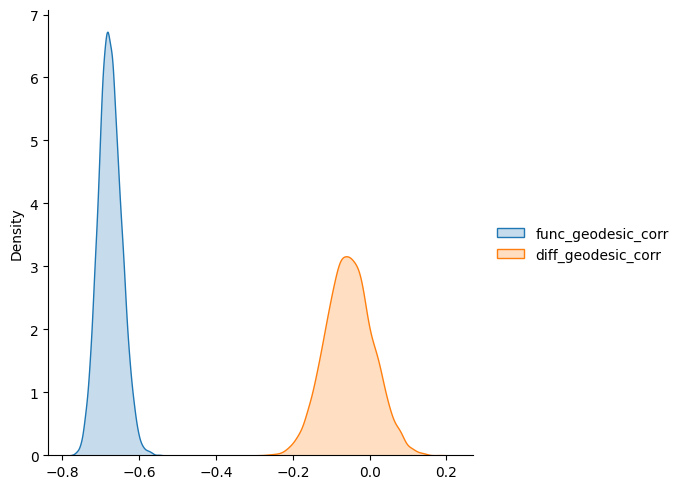

In [141]:
sns.displot(boot_df, kind="kde", fill=True)

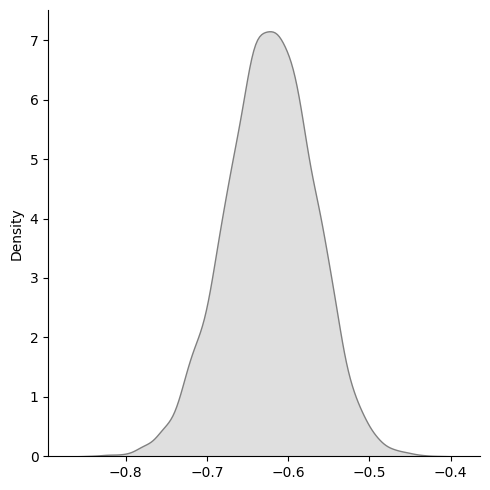

In [142]:
sns.displot(bootdiff, kind="kde", fill=True, color="grey")

In [143]:
bootdiffsort = np.sort(bootdiff);
alpha = 0.05

hi = np.floor((1-alpha/2)*nboot+.5)
lo = np.floor((alpha/2)*nboot+.5)

In [144]:
ci_high = bootdiffsort[int(hi)]
ci_low = bootdiffsort[int(lo)]

In [145]:
bootdiff.mean()

-0.623050909408041

In [146]:
diffci = [ci_high, ci_low]
diffci

[-0.5207858373402952, -0.7308374787046514]

#### graph with yeo-network

In [120]:
df = pd.DataFrame({'Network':network_parc,
                   'Geodesic':geodesic_parc,
                   'Functional':abs_func_parc,
                   'Structural':diff_parc})

In [63]:
df

Network  Geodesic  Functional  Structural
0    1.000000  0.718208    0.563640    0.805695
1    2.130435  0.756606    0.164174    0.112599
2    1.000000  0.756608    0.138740    0.433660
3    1.000000  0.719054    0.377697    0.731491
4    1.000000  0.779794    0.315332    0.684552
..        ...       ...         ...         ...
355  7.000000  0.442331    0.595161    0.202580
356  6.804878  0.560568    0.549909    0.163962
357  4.146341  0.216424    0.547436    0.294434
358  5.725000  0.309827    0.557818    0.181482
359  6.666667  0.199730    0.747320    0.591108

[360 rows x 4 columns]

In [61]:
pd.DataFrame(df).to_csv(results_path + 'network_geodesic-func-diff.csv', index=False)

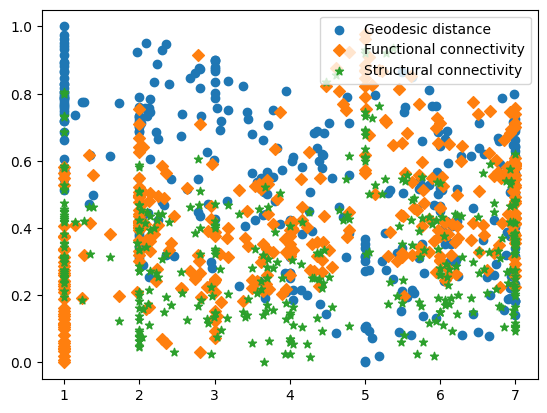

In [68]:
import matplotlib.pyplot as plt
x = network_parc
y = geodesic_parc
plt.scatter(x, y, label='Geodesic distance')
x = network_parc
y = func_parc
plt.scatter(x, y, marker='D', label='Functional connectivity')
x = network_parc
y = diff_parc
plt.scatter(x, y, marker='*', label='Structural connectivity')
plt.legend(loc='best')
plt.show()

In [162]:
network_conn = pd.read_csv(results_path + 'network_geodesic-func-diff.csv')

In [163]:
network_conn

Network  Geodesic  Functional  Structural
0        1.0  0.718208    0.519885    0.805695
1        2.0  0.756606    0.106873    0.112599
2        1.0  0.756608    0.103628    0.433660
3        1.0  0.719054    0.316383    0.731491
4        1.0  0.779794    0.253073    0.684552
..       ...       ...         ...         ...
355      7.0  0.442331    0.571793    0.202580
356      6.0  0.560568    0.511467    0.163962
357      4.0  0.216424    0.522263    0.294434
358      5.0  0.309827    0.535859    0.181482
359      6.0  0.199730    0.721977    0.591108

[360 rows x 4 columns]

In [164]:
network_sorted = network_conn.sort_values(by=['Geodesic'])
network_sorted

Network  Geodesic  Functional  Structural
345      5.0  0.000001    0.975428    0.920246
165      5.0  0.004613    0.958099    0.929370
343      5.0  0.020132    0.857985    0.762068
163      5.0  0.072954    0.809045    0.728595
93       6.0  0.077398    0.585695    0.327703
..       ...       ...         ...         ...
325      2.0  0.950890    0.160938    0.342671
337      1.0  0.962669    0.037436    0.311989
195      1.0  0.973453    0.014742    0.425778
198      1.0  1.000000    0.044072    0.276658
119      NaN       NaN    0.890424    0.689449

[360 rows x 4 columns]

In [165]:
network_conn_melt = network_sorted.melt(id_vars=['Network'], value_vars=['Geodesic', 'Functional','Structural'], var_name='Connectivity')
network_conn_melt

Network Connectivity     value
0         5.0     Geodesic  0.000001
1         5.0     Geodesic  0.004613
2         5.0     Geodesic  0.020132
3         5.0     Geodesic  0.072954
4         6.0     Geodesic  0.077398
...       ...          ...       ...
1075      2.0   Structural  0.342671
1076      1.0   Structural  0.311989
1077      1.0   Structural  0.425778
1078      1.0   Structural  0.276658
1079      NaN   Structural  0.689449

[1080 rows x 3 columns]

In [166]:
network_conn_melt["Network"].dropna().unique().reshape(7)

array([5., 6., 4., 7., 3., 2., 1.])

In [167]:
network_names

['Visual',
 'Somatomotor',
 'Dorsal Attention',
 'Ventral Attention',
 'Limbic',
 'Frontoparietal',
 'Default mode']

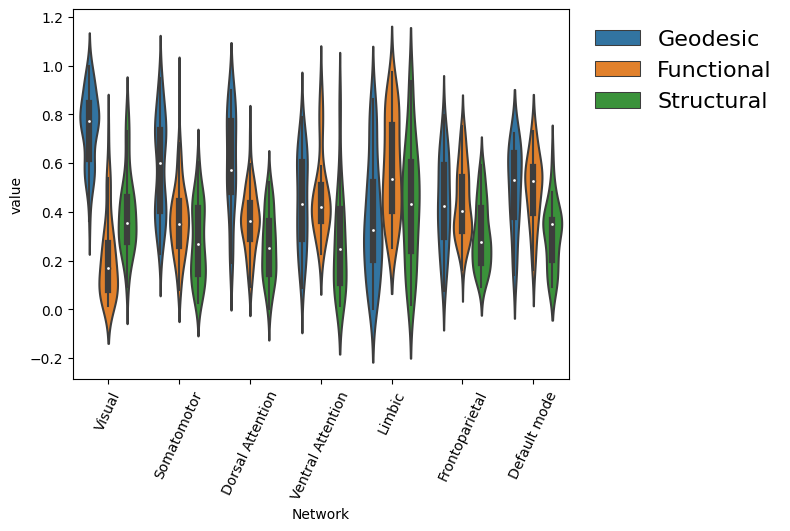

In [168]:
#ordered = df_mpg_filtered.groupby('Manufacturer').median().sort_values('value', ascending=False).index
#my_order = network_conn_melt.groupby(by=["Connectivity"])["value"].mean().iloc[0]
ax = sns.violinplot(data=network_conn_melt, x="Network", y="value", hue='Connectivity')
ax.set_xticklabels(network_names, rotation=65)
plt.legend(frameon=False, loc="upper right", fontsize=16, bbox_to_anchor=(1.45, 1))
#plt.xticks(network_conn_melt["Network"].dropna().unique().reshape(7), network_names, rotation=65)
plt.show()

In [169]:
network_mean = network_conn.groupby('Network').mean()
network_std = network_conn.groupby('Network').std()

In [170]:
network_std.rename(columns = {'Geodesic':'Geodesic-std', 'Functional':'Functional-std', 'Structural':'Structural-std'}, inplace = True)
network_std

Geodesic-std  Functional-std  Structural-std
Network                                              
1.0          0.149193        0.167774        0.164298
2.0          0.203530        0.150683        0.157133
3.0          0.208808        0.127814        0.138388
4.0          0.189642        0.170391        0.206830
5.0          0.240916        0.207909        0.244904
6.0          0.186471        0.146738        0.134845
7.0          0.173225        0.145752        0.133493

In [171]:
networks = pd.concat([network_mean, network_std], axis=1)
networks.insert(0,"Network Name", network_names)

In [172]:
networks

Network Name  Geodesic  Functional  Structural  Geodesic-std  \
Network                                                                      
1.0                 Visual  0.744201    0.210951    0.396851      0.149193   
2.0            Somatomotor  0.581629    0.367857    0.277097      0.203530   
3.0       Dorsal Attention  0.604592    0.364856    0.260705      0.208808   
4.0      Ventral Attention  0.445385    0.465150    0.269162      0.189642   
5.0                 Limbic  0.374743    0.580218    0.441872      0.240916   
6.0         Frontoparietal  0.436574    0.437877    0.305017      0.186471   
7.0           Default mode  0.495428    0.491381    0.303692      0.173225   

         Functional-std  Structural-std  
Network                                  
1.0            0.167774        0.164298  
2.0            0.150683        0.157133  
3.0            0.127814        0.138388  
4.0            0.170391        0.206830  
5.0            0.207909        0.244904  
6.0            0.146738        0.134845  
7.0            0.145752        0.133493

In [173]:
sorted_network = networks.sort_values(by=['Geodesic'])
sorted_network

Network Name  Geodesic  Functional  Structural  Geodesic-std  \
Network                                                                      
5.0                 Limbic  0.374743    0.580218    0.441872      0.240916   
6.0         Frontoparietal  0.436574    0.437877    0.305017      0.186471   
4.0      Ventral Attention  0.445385    0.465150    0.269162      0.189642   
7.0           Default mode  0.495428    0.491381    0.303692      0.173225   
2.0            Somatomotor  0.581629    0.367857    0.277097      0.203530   
3.0       Dorsal Attention  0.604592    0.364856    0.260705      0.208808   
1.0                 Visual  0.744201    0.210951    0.396851      0.149193   

         Functional-std  Structural-std  
Network                                  
5.0            0.207909        0.244904  
6.0            0.146738        0.134845  
4.0            0.170391        0.206830  
7.0            0.145752        0.133493  
2.0            0.150683        0.157133  
3.0            0.127814        0.138388  
1.0            0.167774        0.164298

/tmp/ipykernel_213931/2443960596.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sorted_network["Network Name"], rotation=60, fontsize=16, ha="right")


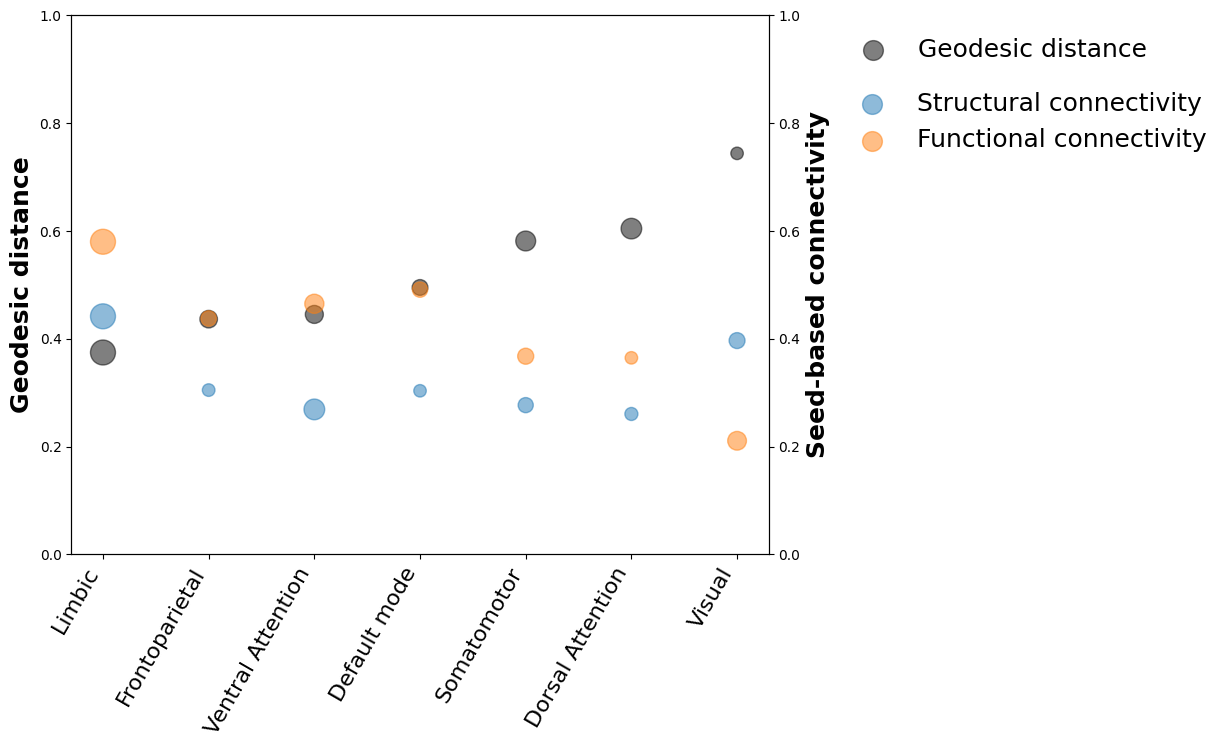

In [174]:
fig, ax = plt.subplots(figsize=(9,7))
ax2=ax.twinx()

s = lambda x : (((x-x.min())/float(x.max()-x.min())+1)*9)**2
ax.scatter(sorted_network["Network Name"], sorted_network['Geodesic'], label='Geodesic distance', c='black', s=s((sorted_network["Geodesic-std"])*300), alpha=0.5)
ax2.scatter(sorted_network["Network Name"], sorted_network['Structural'], label='Structural connectivity', s=s((sorted_network["Structural-std"])*300), alpha=0.5)
ax2.scatter(sorted_network["Network Name"], sorted_network['Functional'], label='Functional connectivity', s=s((sorted_network["Functional-std"])*300), alpha=0.5)

ax.set_ylim(0,1)
ax.set_ylabel('Geodesic distance', weight='bold', fontsize=18)
ax2.set_ylim(0,1)
ax2.set_ylabel('Seed-based connectivity', weight='bold', fontsize=18)


ax.legend(frameon=False, fontsize=18, bbox_to_anchor=(1.575, 1))
ax2.legend(loc=0, fontsize=18, frameon=False, bbox_to_anchor=(1.66, 0.9))
ax.set_xticklabels(sorted_network["Network Name"], rotation=60, fontsize=16, ha="right")
plt.savefig(fig_path + f'Parcellated_Geodesic_StrucFunc_Connectivity_vs_Networks.png', dpi=300, bbox_inches='tight')
plt.show()

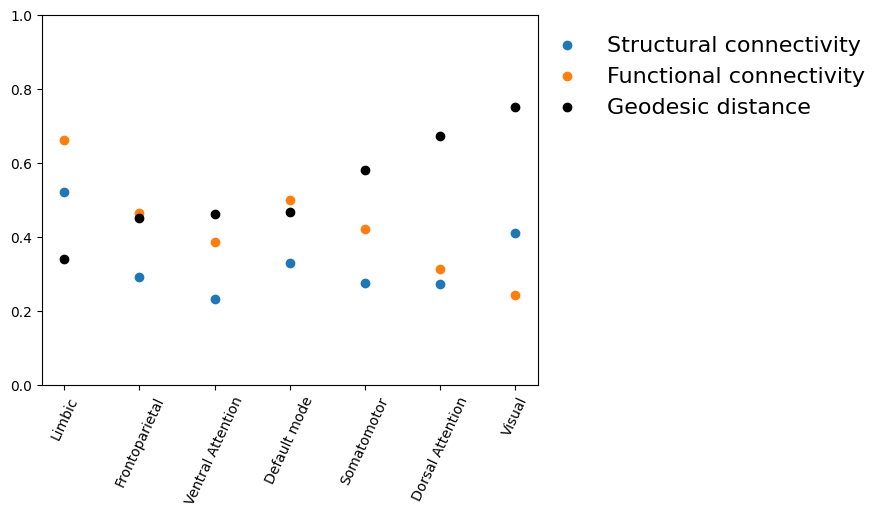

In [211]:
plt.scatter(sorted_network["Network Name"], sorted_network['Structural'], label='Structural connectivity')
plt.scatter(sorted_network["Network Name"], sorted_network['Functional'], label='Functional connectivity')
plt.scatter(sorted_network["Network Name"], sorted_network['Geodesic'], label='Geodesic distance', c='black')
plt.legend(frameon=False, loc="upper right", fontsize=16, bbox_to_anchor=(1.7, 1))
plt.ylim(0,1)
plt.xticks(rotation=65)
plt.show()

In [102]:
network_names

['Visual',
 'Somatomotor',
 'Dorsal Attention',
 'Ventral Attention',
 'Limbic',
 'Frontoparietal',
 'Default mode']

### Func and Diff conn. x VAChT correlation difference

In [106]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [107]:
nregions = 360

In [108]:
a = MicCorr_parc
b = abs_func_parc
c = diff_parc

In [109]:
a[np.isnan(a)] = 0

In [110]:
#Bootstrap (i.e., randomly select sets of regions) and calculate correlation coefficients
nboot = 10000;
bootcorr1 = np.zeros((nboot))
bootcorr2 = np.zeros((nboot))
bootpval1 = np.zeros((nboot))
bootpval2 = np.zeros((nboot))

In [111]:
# chose pearson or spearmanr corr

In [112]:
for B in range(0,nboot):
    bootsample = np.random.randint(0, high=nregions, size=nregions);
    bootcorr1[B], bootpval1[B] = pearsonr(a[bootsample],b[bootsample])
    bootcorr2[B], bootpval2[B] = pearsonr(a[bootsample],c[bootsample])

In [113]:
# Calculate p-value based on the number of bootstraps where correlation of dmri is stronger than rfmri
bootdiff = bootcorr1-bootcorr2
pvalue = 1-(np.sum(bootdiff<0)/nboot)

In [114]:
pvalue

1.0

In [115]:
np.sum(bootdiff<0)

0

In [116]:
boot_df = pd.DataFrame({'func_MicVAChT_corr': bootcorr1, 'diff_MicVAChT_corr':bootcorr2}, columns=['func_MicVAChT_corr', 'diff_MicVAChT_corr'])

In [117]:
boot_df.head(5)

func_MicVAChT_corr  diff_MicVAChT_corr
0            0.468311           -0.124786
1            0.444148           -0.216354
2            0.493792           -0.155220
3            0.426837           -0.122469
4            0.425365           -0.117637

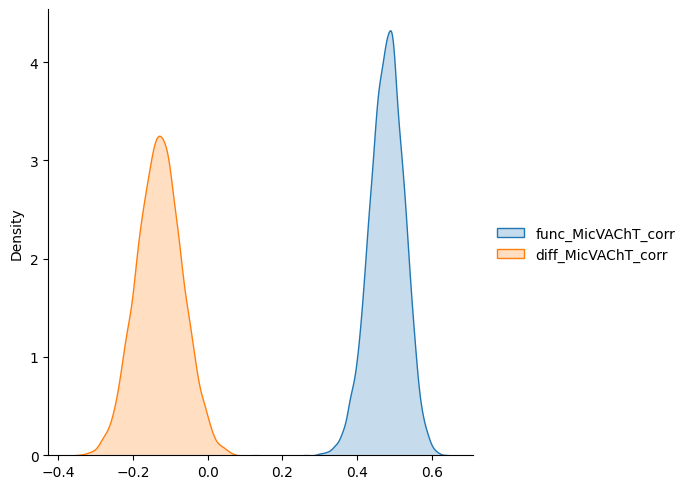

In [118]:
sns.displot(boot_df, kind="kde", fill=True)

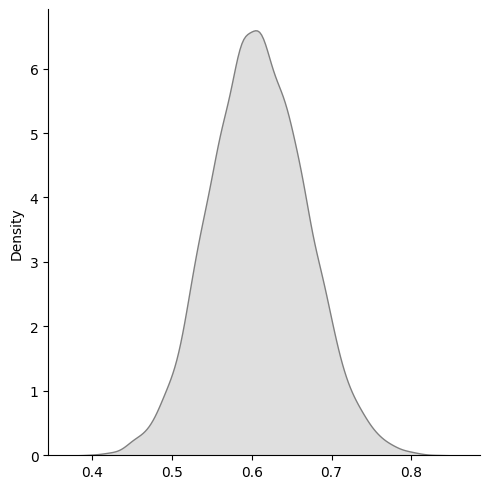

In [119]:
sns.displot(bootdiff, kind="kde", fill=True, color="grey")

In [120]:
bootdiffsort = np.sort(bootdiff);
alpha = 0.05

hi = np.floor((1-alpha/2)*nboot+.5)
lo = np.floor((alpha/2)*nboot+.5)

In [121]:
ci_high = bootdiffsort[int(hi)]
ci_low = bootdiffsort[int(lo)]

In [122]:
bootdiff.mean()

0.6078149553922954

In [123]:
diffci = [ci_high, ci_low]
diffci

[0.7274444104223232, 0.49273926739741336]

### Func and Diff conn. x Fiber Length correlation difference

In [60]:
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [61]:
nregions = 360

In [62]:
a = fiberLength_parc
b = abs_func_parc
c = diff_parc

In [63]:
a[np.isnan(a)] = 0

In [64]:
#Bootstrap (i.e., randomly select sets of regions) and calculate correlation coefficients
nboot = 10000;
bootcorr1 = np.zeros((nboot))
bootcorr2 = np.zeros((nboot))
bootpval1 = np.zeros((nboot))
bootpval2 = np.zeros((nboot))

In [65]:
# chose pearson or spearmanr corr

In [66]:
for B in range(0,nboot):
    bootsample = np.random.randint(0, high=nregions, size=nregions);
    bootcorr1[B], bootpval1[B] = pearsonr(a[bootsample],b[bootsample])
    bootcorr2[B], bootpval2[B] = pearsonr(a[bootsample],c[bootsample])

In [67]:
# Calculate p-value based on the number of bootstraps where correlation of dmri is stronger than rfmri
bootdiff = bootcorr1-bootcorr2
pvalue = 1-(np.sum(bootdiff<0)/nboot)

In [68]:
pvalue

0.0

In [69]:
np.sum(bootdiff<0)

10000

In [70]:
boot_df = pd.DataFrame({'func_FiberLength_corr': bootcorr1, 'diff_FiberLength_corr':bootcorr2}, columns=['func_FiberLength_corr', 'diff_FiberLength_corr'])

In [71]:
boot_df.head(5)

func_FiberLength_corr  diff_FiberLength_corr
0              -0.270921               0.541197
1              -0.191674               0.570665
2              -0.270010               0.472622
3              -0.196274               0.562300
4              -0.218524               0.635771

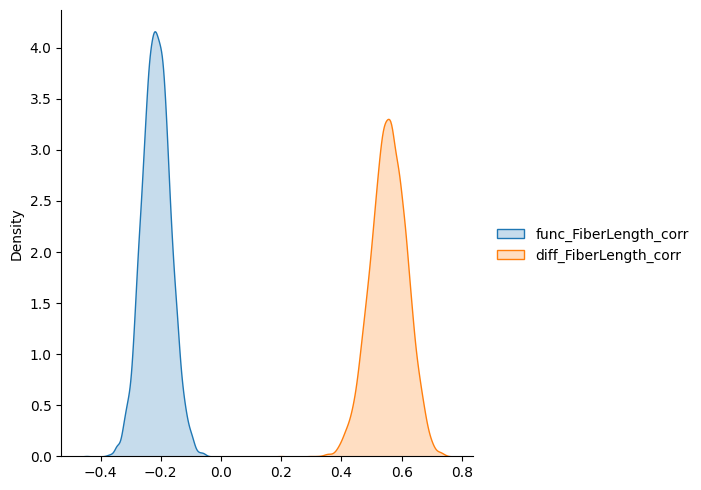

In [72]:
sns.displot(boot_df, kind="kde", fill=True)

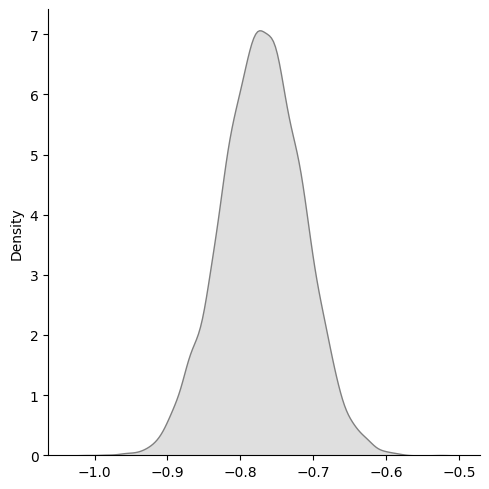

In [73]:
sns.displot(bootdiff, kind="kde", fill=True, color="grey")

In [74]:
bootdiffsort = np.sort(bootdiff);
alpha = 0.05

hi = np.floor((1-alpha/2)*nboot+.5)
lo = np.floor((alpha/2)*nboot+.5)

In [75]:
ci_high = bootdiffsort[int(hi)]
ci_low = bootdiffsort[int(lo)]

In [76]:
bootdiff.mean()

-0.7709007130838414

In [77]:
diffci = [ci_high, ci_low]
diffci

[-0.6644257927903304, -0.8809470340371753]

#### ANOVA between networks

In [295]:
network_conn = pd.read_csv(results_path + 'network_geodesic-func-diff.csv')
network_conn

Network  Geodesic  Functional  Structural
0        1.0  0.718208    0.563640    0.805695
1        2.0  0.756606    0.164174    0.112599
2        1.0  0.756608    0.138740    0.433660
3        1.0  0.719054    0.377697    0.731491
4        1.0  0.779794    0.315332    0.684552
..       ...       ...         ...         ...
355      7.0  0.442331    0.595161    0.202580
356      7.0  0.560568    0.549909    0.163962
357      4.0  0.216424    0.547436    0.294434
358      6.0  0.309827    0.557818    0.181482
359      7.0  0.199730    0.747320    0.591108

[360 rows x 4 columns]

In [298]:
import pingouin as pg
aov_geodesic = pg.anova(dv='Geodesic', between='Network', data=network_conn, detailed=True)
aov_geodesic

Source         SS   DF        MS          F         p-unc       np2
0  Network   5.585844    6  0.930974  24.953693  1.170886e-24  0.298416
1   Within  13.132440  352  0.037308        NaN           NaN       NaN

In [299]:
aov_diff = pg.anova(dv='Structural', between='Network', data=network_conn, detailed=True)
aov_diff

Source        SS   DF        MS          F         p-unc       np2
0  Network  2.652928    6  0.442155  16.505073  8.896202e-17  0.219565
1   Within  9.429735  352  0.026789        NaN           NaN       NaN

In [300]:
aov_func = pg.anova(dv='Functional', between='Network', data=network_conn, detailed=True)
aov_func

Source        SS   DF        MS          F         p-unc      np2
0  Network  4.784654    6  0.797442  30.796929  1.065525e-29  0.34424
1   Within  9.114536  352  0.025894        NaN           NaN      NaN